**CNRA Assessment**

Fanling Liu

In [1]:
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

**Task 1**

In [2]:
# Read data
mat_data = sio.loadmat('/home/mmp/Downloads/extendedMetrics 1.mat')

# Display the keys and potentially some sample data to understand what's stored
mat_data_dic = mat_data.keys(), {key: mat_data[key] for key in mat_data if key != '__header__' and key != '__version__' and key != '__globals__'}

What the generated .mat file:

- Run_ID: The unique identifier for the run being processed.
- DIV (Days In Vitro): The number of days since the neurons were plated, calculated based on the recording date and the DIV 0 date provided.
- Well: Identifies the specific well on a chip from which the data is recorded.
- Chip_ID: Identifier for the chip used in the experiments.
- NeuronType: Type of neurons recorded based on the source specified in the reference table.
- networkAPFreqBins: Histogram counts of instantaneous action potential frequencies across the entire network.
- networkAPFreqEdges: Edges defining the bins for the histogram of network-wide action potential frequencies.
- burstAPFreqBins: Histogram counts of action potential frequencies within bursts.
- burstAPFreqEdges: Edges defining the bins for the histogram of action potential frequencies within bursts.
- nonburstAPFreqBins: Histogram counts of action potential frequencies outside of bursts.
- nonburstAPFreqEdges: Edges defining the bins for the histogram of action potential frequencies outside of bursts.

**Task 2**

In [3]:
# Load the reference data
ref_data = pd.read_csv('KCNT1_T4_ref.csv')
ref_data.head()

Date  Div          Assay  Run #      ID Wells_Recorded  \
0  04/16/24    4      Sparse 7x      1  M08026    1,2,3,4,5,6   
1  04/16/24    4  Network Today      4  M08026    1,2,3,4,5,6   
2  04/16/24    4      Sparse 7x      6  M07299      1,2,3,4,5   
3  04/16/24    4  Network Today      7  M07299      1,2,3,4,5   
4  04/16/24    4      Sparse 7x      8  M08034    1,2,3,4,5,6   

                  Neuron Source  
0  HOM, HOM, HOM, HET, HET, HET  
1  HOM, HOM, HOM, HET, HET, HET  
2       HOM, HOM, HOM, HOM, HET  
3       HOM, HOM, HOM, HOM, HET  
4  HOM, HOM, HOM, HET, HET, HET

In [4]:
# Extract data and store in a dictionary
all_records = np.squeeze(mat_data['allExtMetrics'])
refined_results = []   
for record in all_records:
    if record.size > 0:
            for item in record:
                if item.size > 0:
                    div = item[0][0][0]['DIV'][0][0]
                    well = item[0][0][0]['Well'][0][0]
                    Run_ID = item[0][0][0]['Run_ID'][0][0]
                    Chip_ID = item[0][0][0]['Chip_ID'][0]
                    NeuronType = item[0][0][0]['NeuronType'][0]
                    networkAPFreqBins = item[0][0][0]['networkAPFreqBins'][0]
                    networkAPFreqEdges = item[0][0][0]['networkAPFreqEdges'][0]
                    burstAPFreqBins = item[0][0][0]['burstAPFreqBins'][0]
                    burstAPFreqEdges = item[0][0][0]['burstAPFreqEdges'][0]
                    nonburstAPFreqBins = item[0][0][0]['nonburstAPFreqBins'][0]
                    nonburstAPFreqEdges = item[0][0][0]['nonburstAPFreqEdges'][0]
                    refined_entry = {
                        'Run_ID': Run_ID,
                        'Chip_ID': Chip_ID,
                        'DIV': div,
                        'WellRecord': well,
                        'NeuronType': NeuronType,
                        'networkAPFreqBins': networkAPFreqBins,
                        'networkAPFreqEdges': networkAPFreqEdges,
                        'burstAPFreqBins': burstAPFreqBins,
                        'burstAPFreqEdges': burstAPFreqEdges,
                        'nonburstAPFreqBins': nonburstAPFreqBins,
                        'nonburstAPFreqEdges': nonburstAPFreqEdges
                    }
                    refined_results.append(refined_entry)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [5]:
# get the div 21 data
div_21_data = [entry for entry in refined_results if entry['DIV'] == 21]

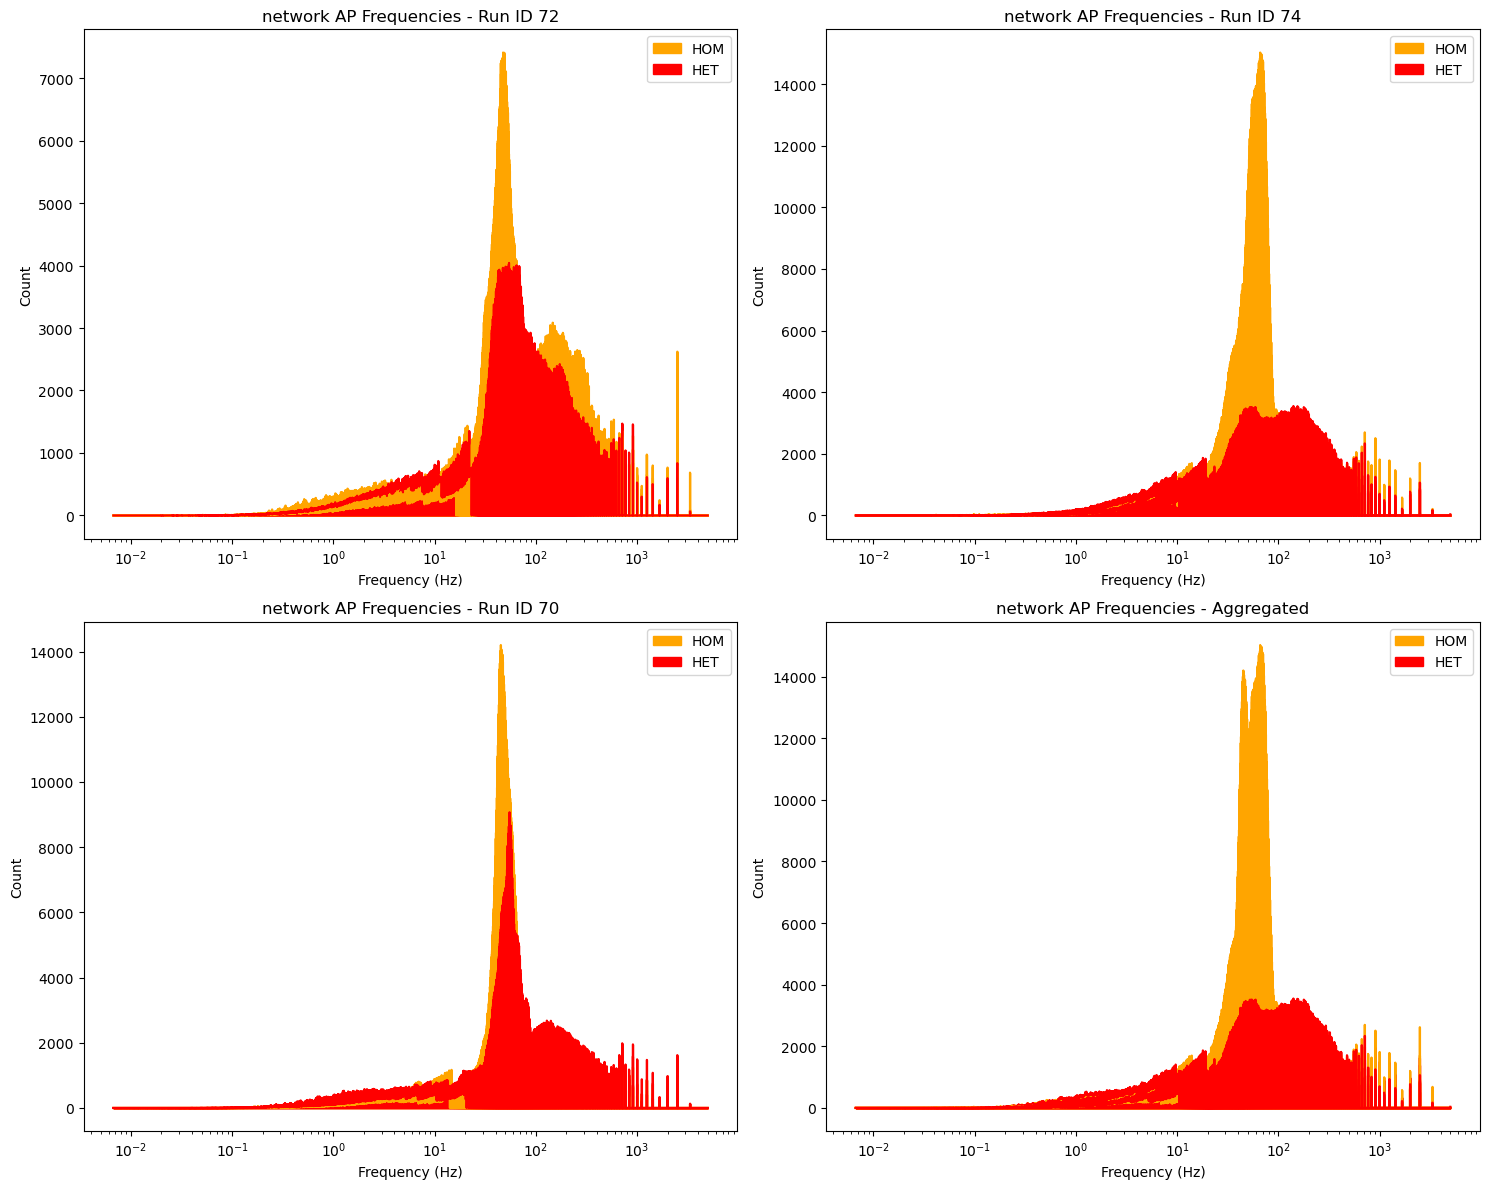

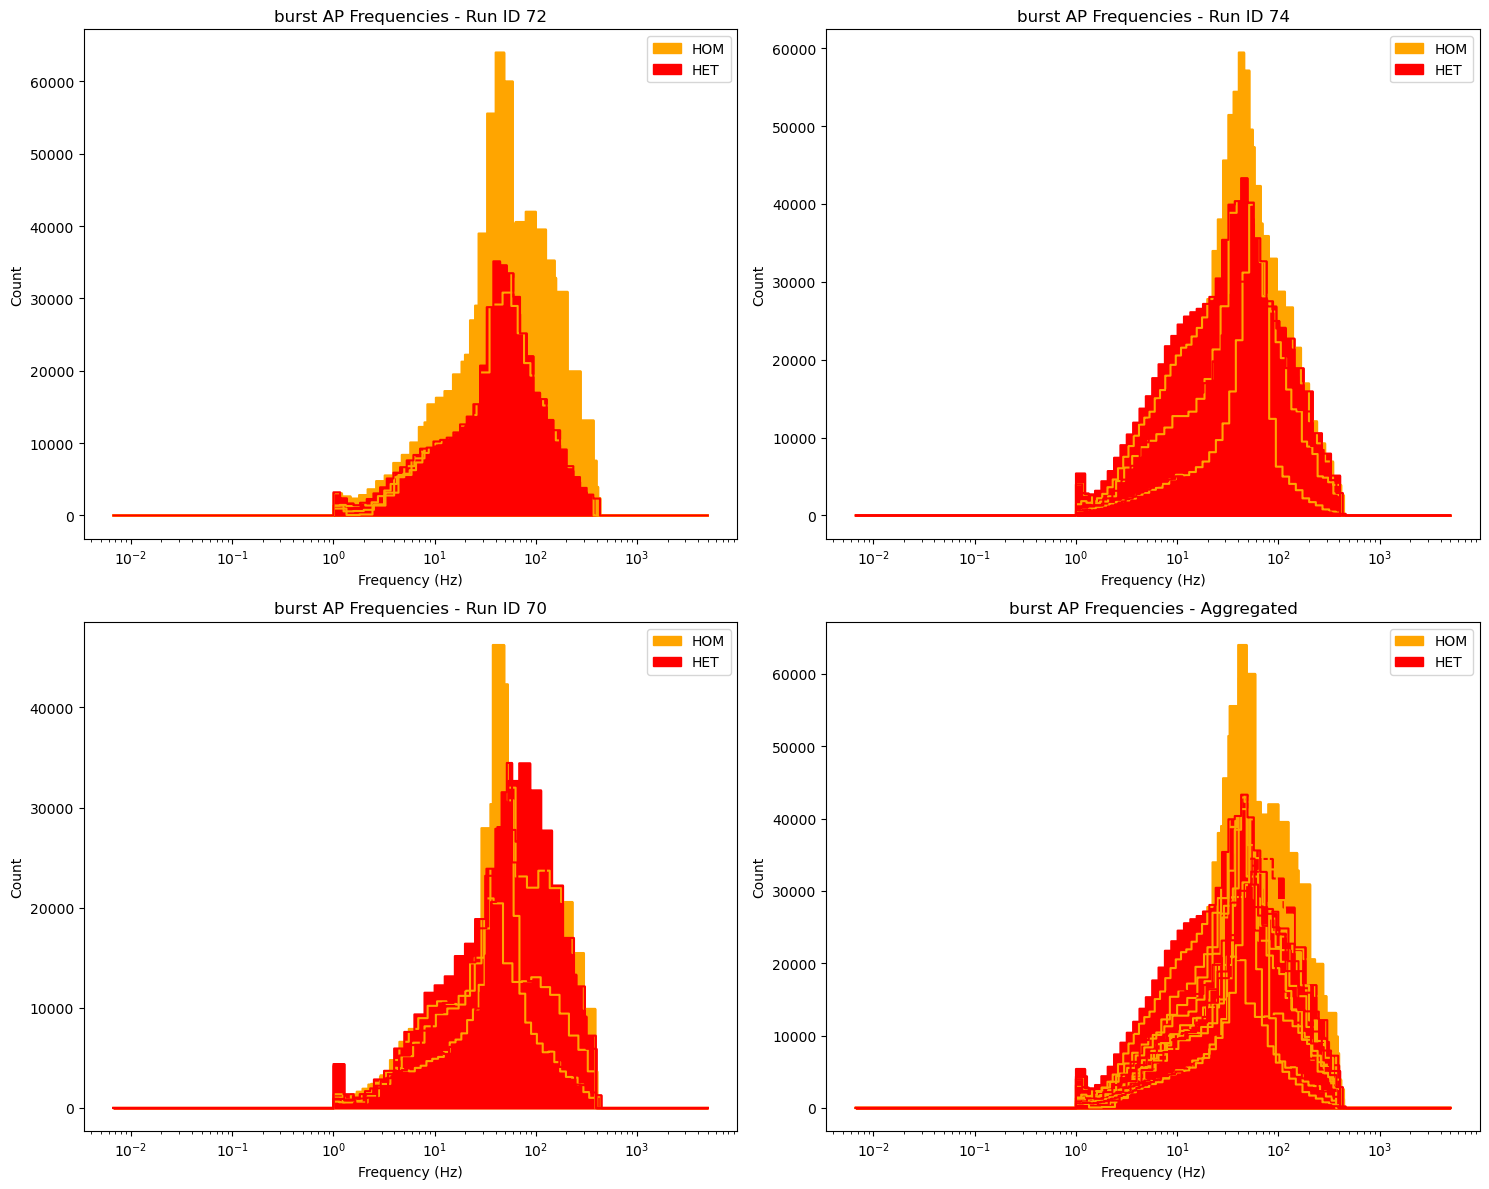

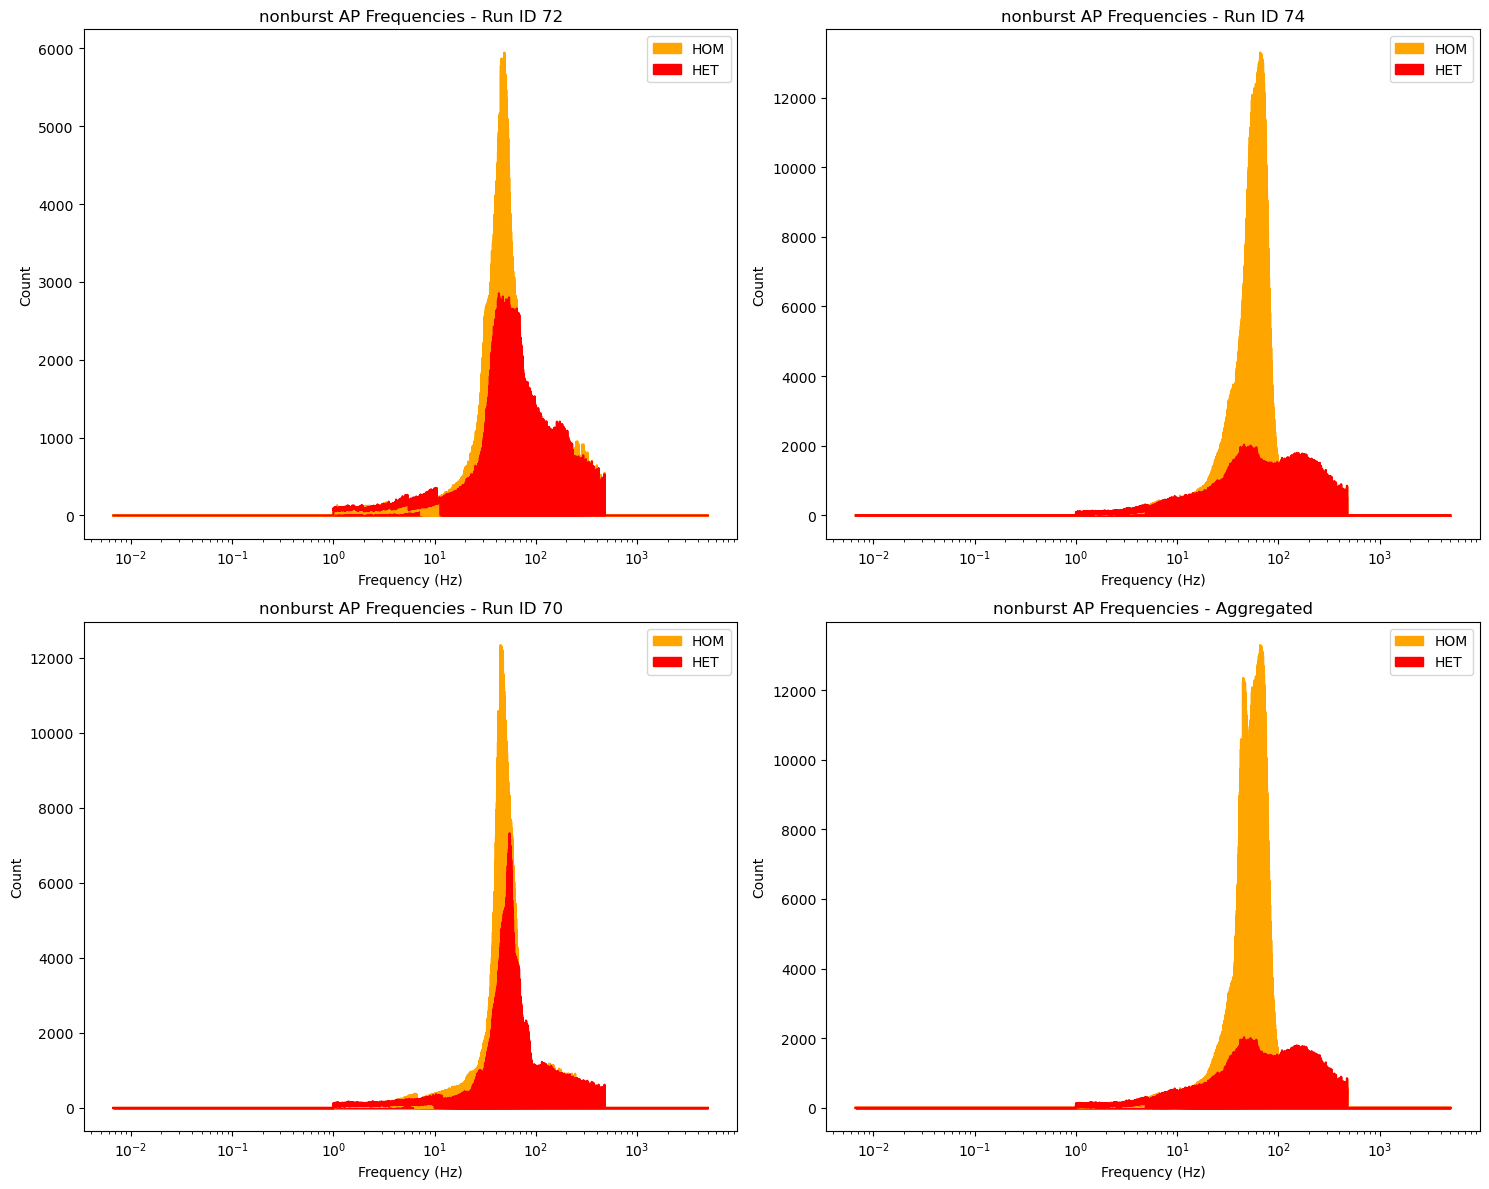

In [6]:
def plot_histograms(data):
    colors = {'HOM': 'orange', 'HET': 'red'}
    unique_run_ids = list(set(item['Run_ID'] for item in data))[:3]  # Ensure this matches the IDs you have.

    # Define the keys for different AP frequency categories
    keys = ['networkAPFreqBins', 'burstAPFreqBins', 'nonburstAPFreqBins']

    # Assuming all entries share the same edges
    max_edges = None
    for item in data:
        if max_edges is None or len(item['networkAPFreqEdges']) > len(max_edges):
            max_edges = item['networkAPFreqEdges']

    # Create figures for each category
    for key in keys:
        plt.figure(figsize=(15, 12))  # Figure size as specified

        # Plot for each Run_ID and for aggregate in the 4th subplot
        subplot_idx = 1
        for run_id in unique_run_ids + ['Aggregate']:
            ax = plt.subplot(2, 2, subplot_idx)
            subplot_idx += 1  # Increment subplot index

            if run_id != 'Aggregate':
                run_data = [item for item in data if item['Run_ID'] == run_id]
            else:
                run_data = data  # Aggregate uses all data

            aggregate_data = {nt: np.zeros_like(max_edges[:-1]) for nt in ['HOM', 'HET']} # Initialize aggregate data
            
            neuron_legend_added = {'HOM': False, 'HET': False}  # To control legend entry for each subplot

            for item in run_data:
                bins = item[key]
                edges = item[key.replace('Bins', 'Edges')]
                neuron_type = item['NeuronType']

                # Interpolate to the standardized edges
                interp = interp1d(edges[:-1], bins, kind='previous', bounds_error=False, fill_value=0)
                standardized_bins = interp(max_edges[:-1])

                # Update aggregate data
                aggregate_data[neuron_type] += standardized_bins

                # Plot data with transparency
                alpha = 1.0
                plt.fill_between(max_edges[:-1], standardized_bins, step='post', alpha=alpha, color=colors[neuron_type], label=neuron_type if not neuron_legend_added[neuron_type] else "")
                plt.plot(max_edges[:-1], standardized_bins, drawstyle='steps-post', color=colors[neuron_type], alpha=alpha)
                
                # Ensure legend is added once per neuron type across all subplots
                if not neuron_legend_added[neuron_type]:
                    neuron_legend_added[neuron_type] = True

            plt.xscale('log')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Count')
            plt.title(f"{key.replace('APFreqBins', ' AP Frequencies')} - {'Aggregated' if run_id == 'Aggregate' else f'Run ID {run_id}'}")
            plt.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

plot_histograms(div_21_data)

__Explanation:__

In the following plots, I visualize activity data across different runs and in an aggregated manner. The data is categorized into three types: burst activity, non-burst activity, and network activity. For each category, I generate a set of four plots: three for the individual Run_IDs and one for the aggregated data. The first three subplots in each set display the activity data for three specified Run_IDs, while the fourth subplot shows the aggregated data combining all Run_IDs. 

**Task 3**

__Explanation:__

The plots require improvement as some data points overlap. Notably, the orange section cover the red section. To address this, we could try to adjust the transparency of the data. 

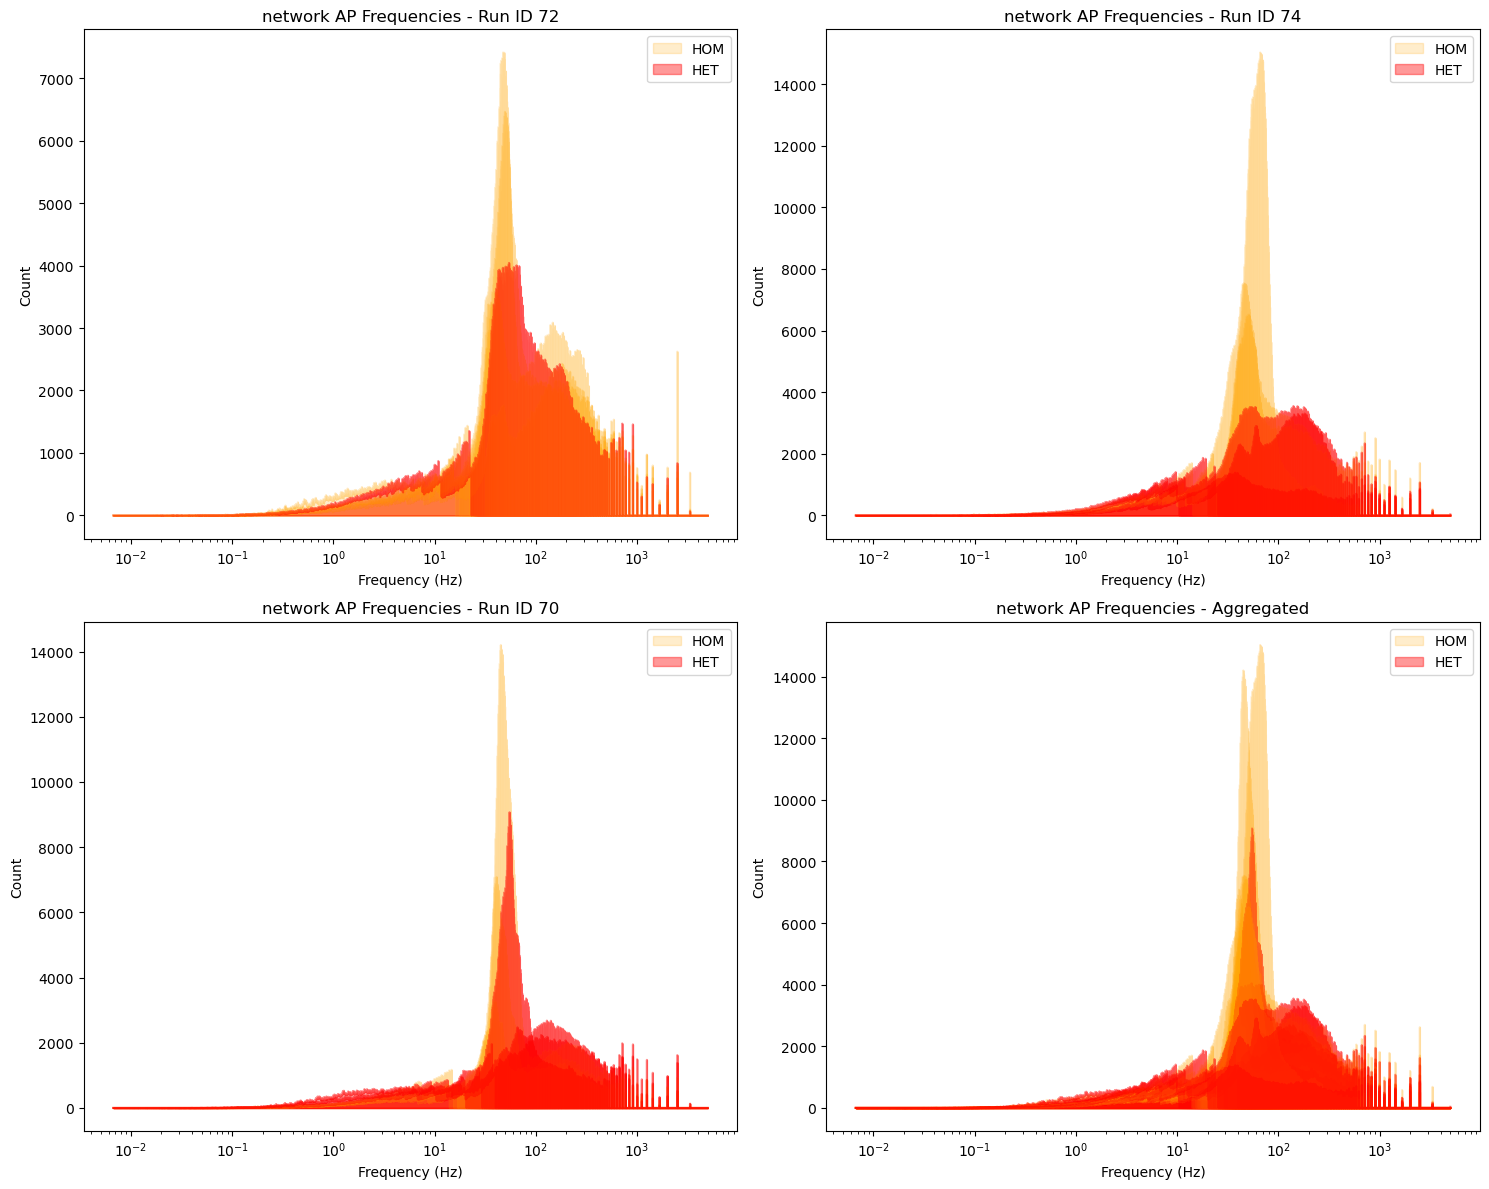

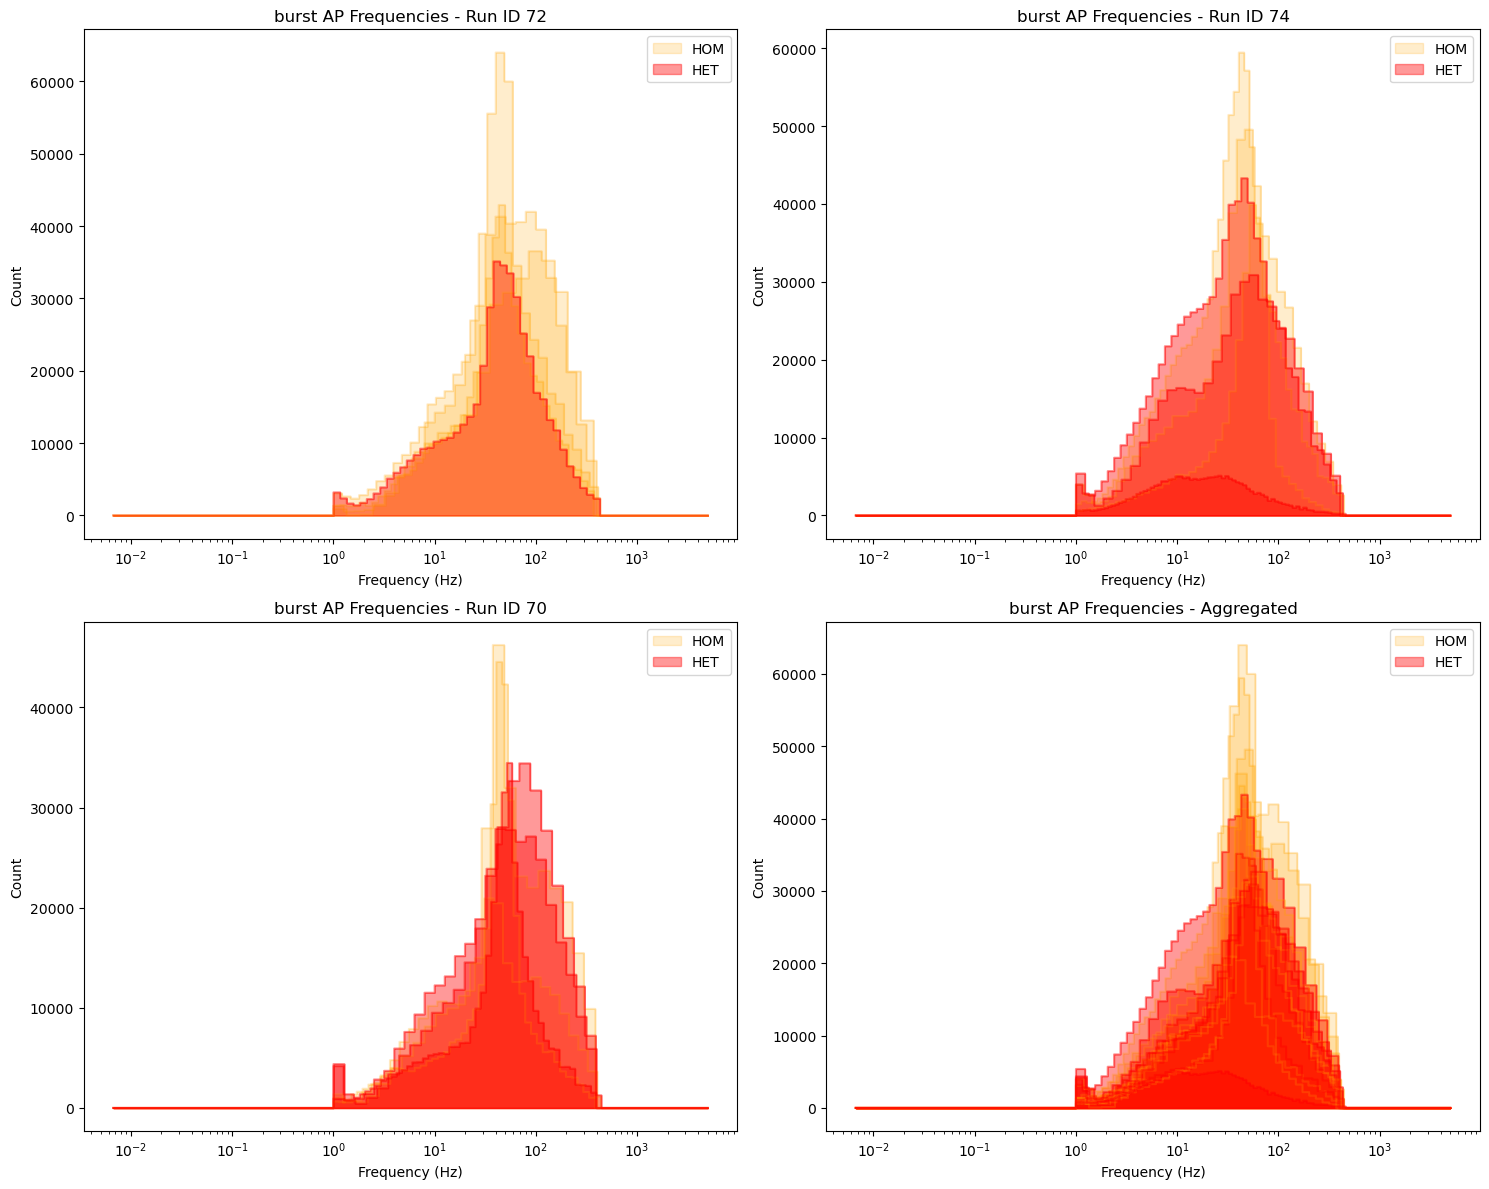

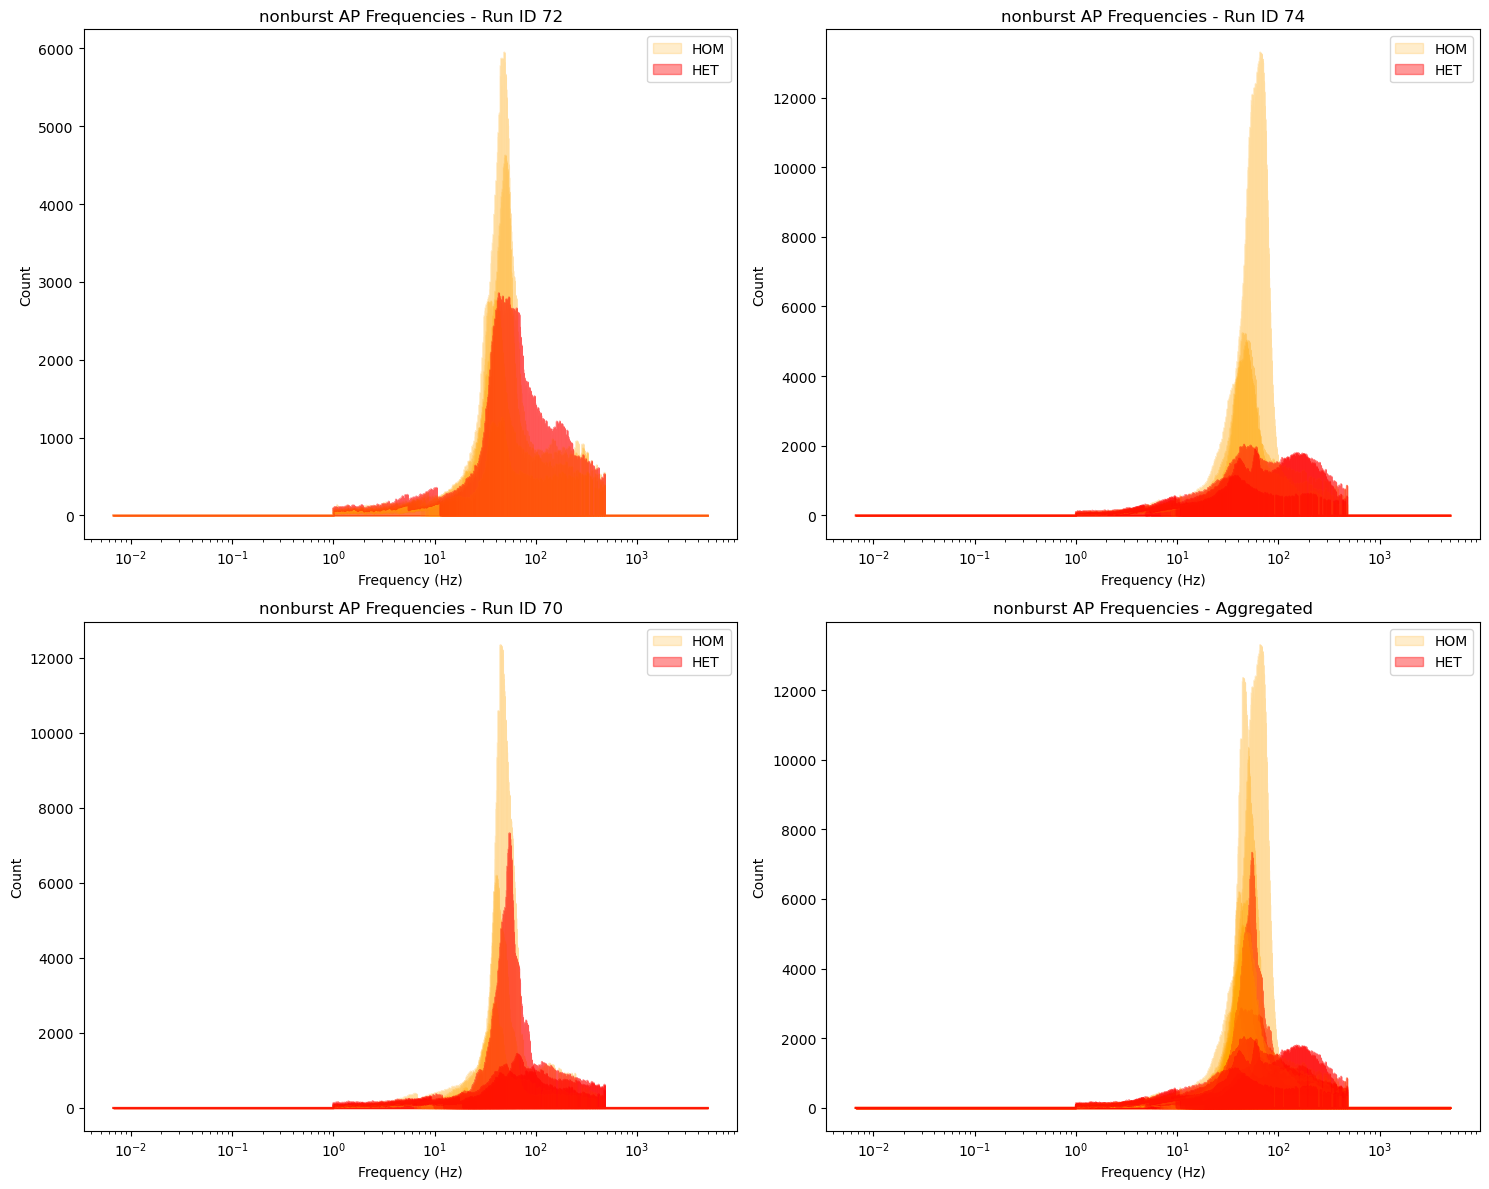

In [7]:
def plot_histograms_update(data):
    colors = {'HOM': 'orange', 'HET': 'red'}
    transparencies = {'HOM': 0.2, 'HET': 0.4}
    unique_run_ids = list(set(item['Run_ID'] for item in data))[:3]  # Ensure this matches the IDs you have.

    # Define the keys for different AP frequency categories
    keys = ['networkAPFreqBins', 'burstAPFreqBins', 'nonburstAPFreqBins']

    # Assuming all entries share the same edges
    max_edges = None
    for item in data:
        if max_edges is None or len(item['networkAPFreqEdges']) > len(max_edges):
            max_edges = item['networkAPFreqEdges']

    # Create figures for each category
    for key in keys:
        plt.figure(figsize=(15, 12))  # Figure size as specified

        # Plot for each Run_ID and for aggregate in the 4th subplot
        subplot_idx = 1
        for run_id in unique_run_ids + ['Aggregate']:
            ax = plt.subplot(2, 2, subplot_idx)
            subplot_idx += 1  # Increment subplot index

            if run_id != 'Aggregate':
                run_data = [item for item in data if item['Run_ID'] == run_id]
            else:
                run_data = data  # Aggregate uses all data

            aggregate_data = {nt: np.zeros_like(max_edges[:-1]) for nt in ['HOM', 'HET']} # Initialize aggregate data
            
            neuron_legend_added = {'HOM': False, 'HET': False}  # To control legend entry for each subplot

            for item in run_data:
                bins = item[key]
                edges = item[key.replace('Bins', 'Edges')]
                neuron_type = item['NeuronType']

                # Interpolate to the standardized edges
                interp = interp1d(edges[:-1], bins, kind='previous', bounds_error=False, fill_value=0)
                standardized_bins = interp(max_edges[:-1])

                # Update aggregate data
                aggregate_data[neuron_type] += standardized_bins

                # Plot data with transparency
                alpha = transparencies[neuron_type]
                plt.fill_between(max_edges[:-1], standardized_bins, step='post', alpha=alpha, color=colors[neuron_type], label=neuron_type if not neuron_legend_added[neuron_type] else "")
                plt.plot(max_edges[:-1], standardized_bins, drawstyle='steps-post', color=colors[neuron_type], alpha=alpha)
                
                # Ensure legend is added once per neuron type across all subplots
                if not neuron_legend_added[neuron_type]:
                    neuron_legend_added[neuron_type] = True

            plt.xscale('log')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Count')
            plt.title(f"{key.replace('APFreqBins', ' AP Frequencies')} - {'Aggregated' if run_id == 'Aggregate' else f'Run ID {run_id}'}")
            plt.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

plot_histograms_update(div_21_data)

__Explanation:__

This looks better. This could be further enhanced if we implement line plots, drawing lines from the midpoint of each egde. This adjustment would help prevent data overlap, ensuring clearer visualization of each dataset.

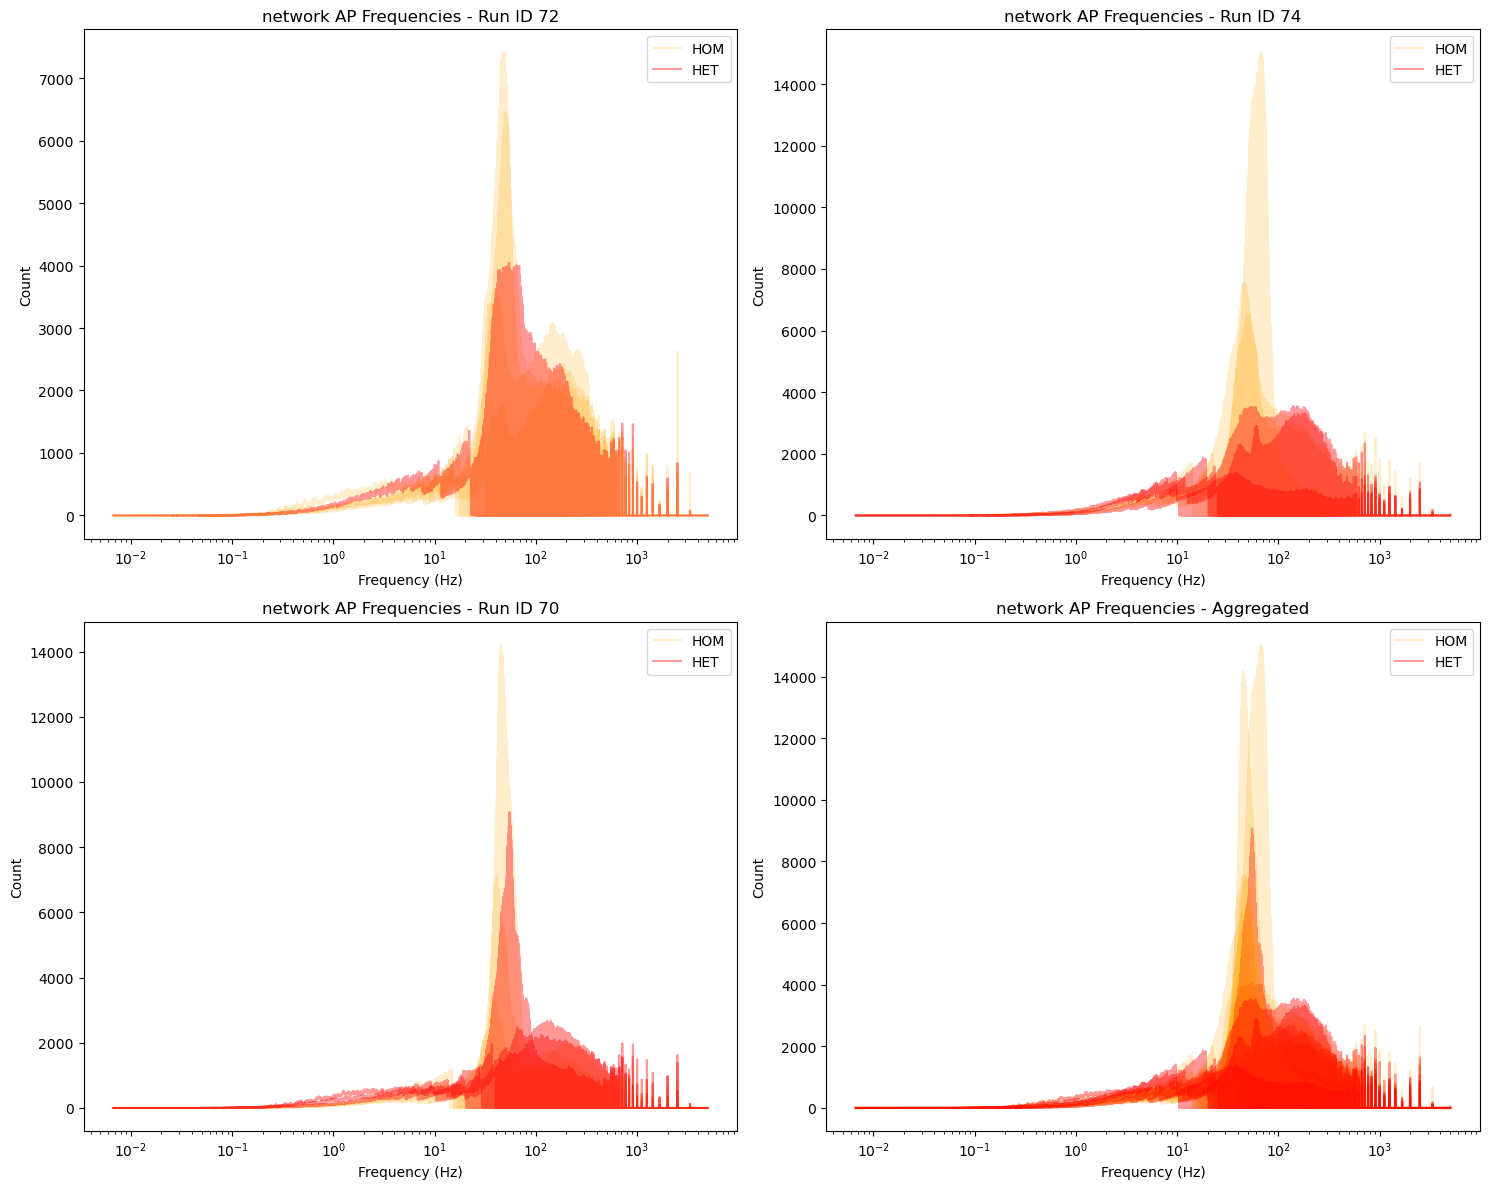

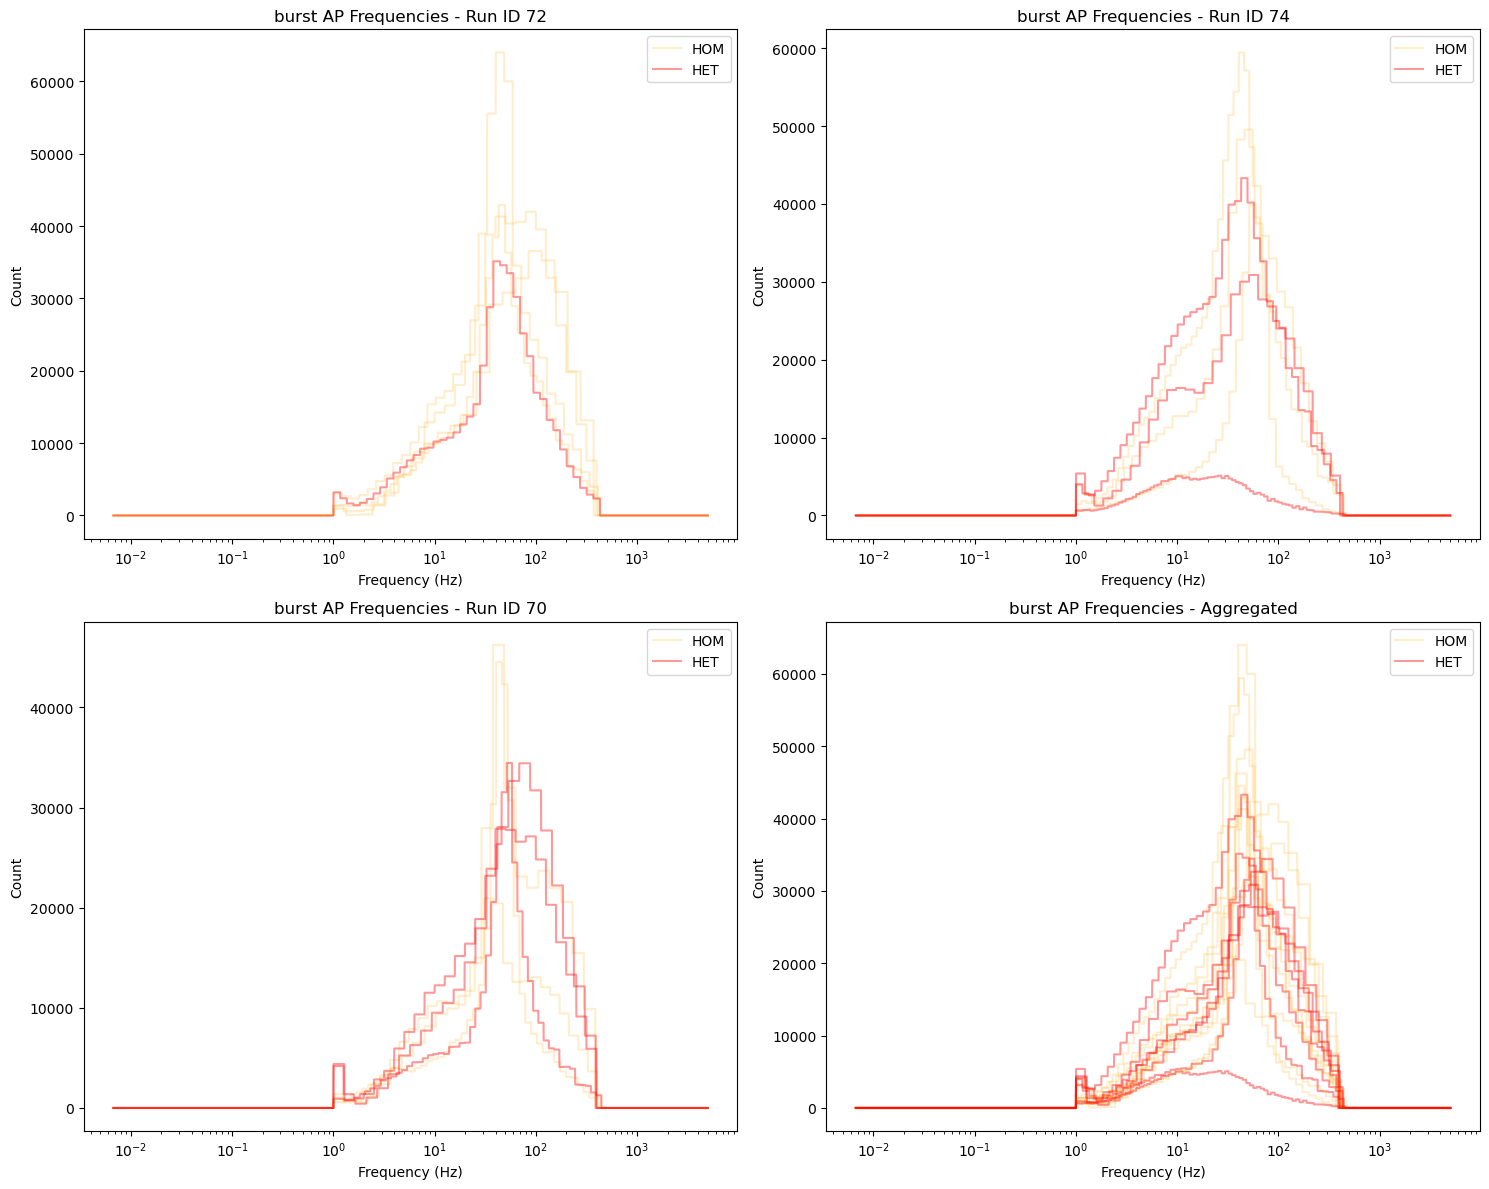

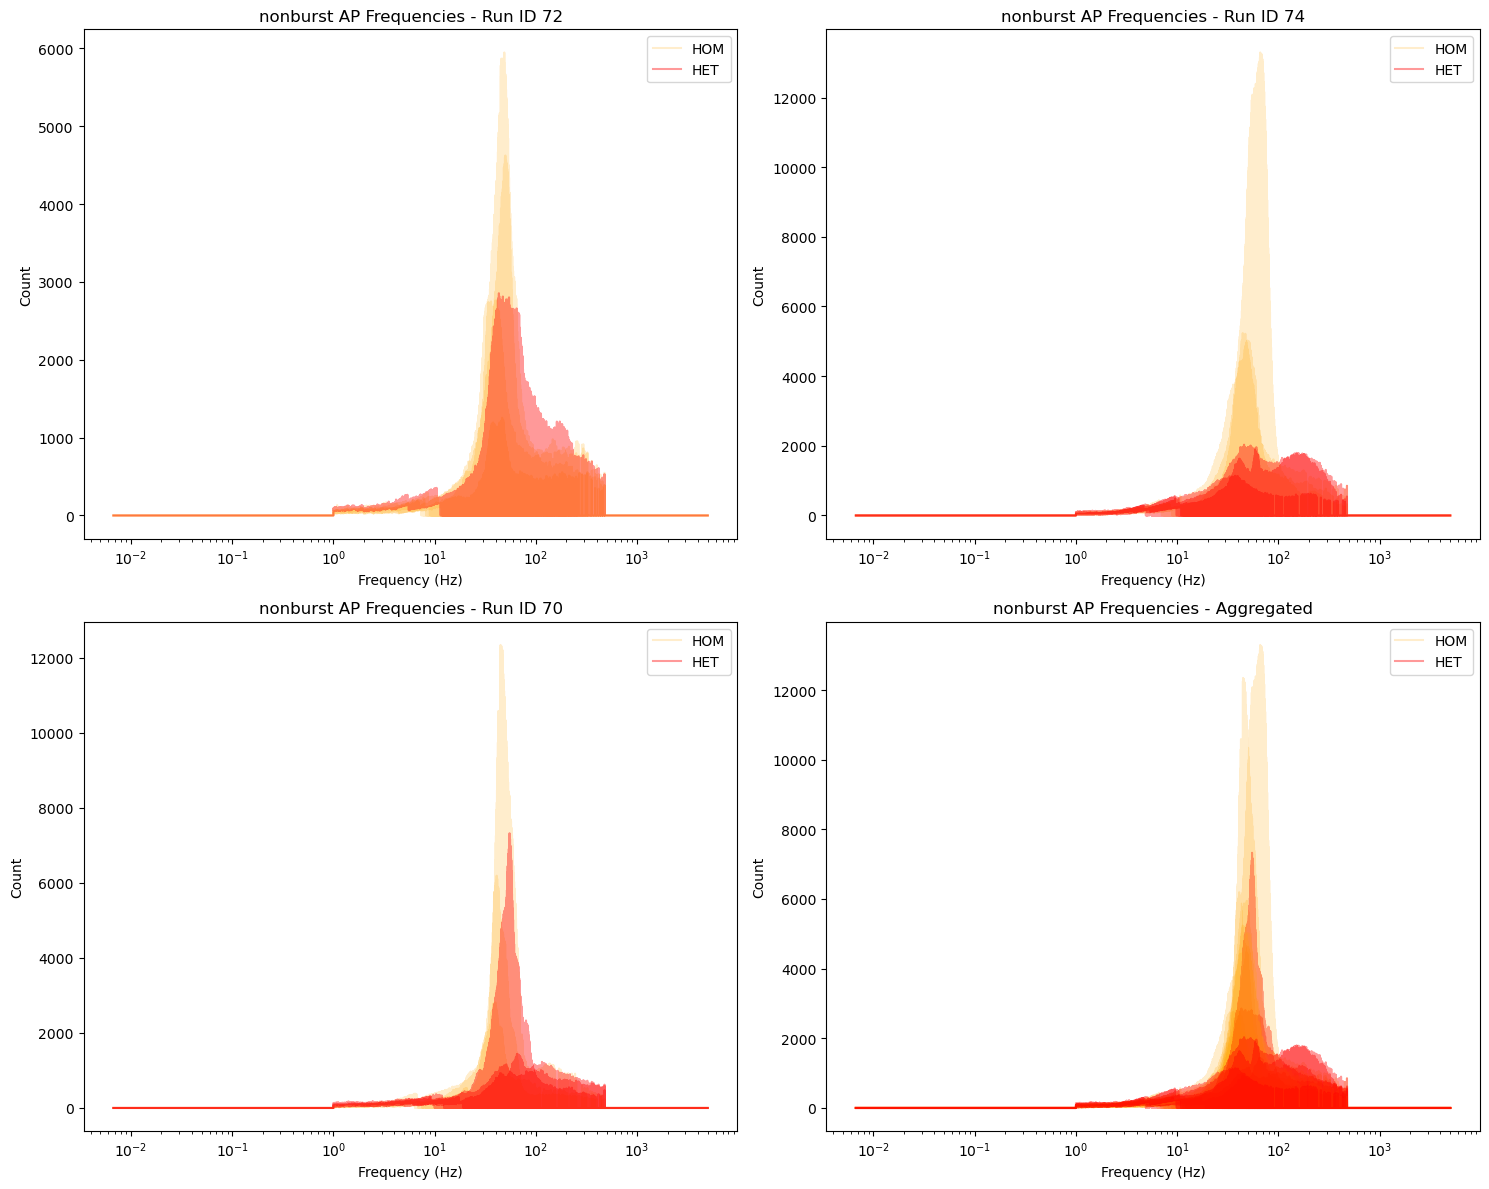

In [8]:
def plot_line(data):
    colors = {'HOM': 'orange', 'HET': 'red'}
    transparencies = {'HOM': 0.2, 'HET': 0.4}
    unique_run_ids = list(set(item['Run_ID'] for item in data))[:3]  # Ensure this matches the IDs you have.

    # Define the keys for different AP frequency categories
    keys = ['networkAPFreqBins', 'burstAPFreqBins', 'nonburstAPFreqBins']

    # Assuming all entries share the same edges
    max_edges = None
    for item in data:
        if max_edges is None or len(item['networkAPFreqEdges']) > len(max_edges):
            max_edges = item['networkAPFreqEdges']

    # Create figures for each category
    for key in keys:
        plt.figure(figsize=(15, 12))  # Figure size as specified

        # Plot for each Run_ID and for aggregate in the 4th subplot
        subplot_idx = 1
        for run_id in unique_run_ids + ['Aggregate']:
            ax = plt.subplot(2, 2, subplot_idx)
            subplot_idx += 1  # Increment subplot index

            if run_id != 'Aggregate':
                run_data = [item for item in data if item['Run_ID'] == run_id]
            else:
                run_data = data  # Aggregate uses all data

            aggregate_data = {nt: np.zeros_like(max_edges[:-1]) for nt in ['HOM', 'HET']} # Initialize aggregate data
            
            neuron_legend_added = {'HOM': False, 'HET': False}  # To control legend entry for each subplot

            for item in run_data:
                bins = item[key]
                edges = item[key.replace('Bins', 'Edges')]
                neuron_type = item['NeuronType']

                # Interpolate to the standardized edges
                interp = interp1d(edges[:-1], bins, kind='previous', bounds_error=False, fill_value=0)
                standardized_bins = interp(max_edges[:-1])

                # Update aggregate data
                aggregate_data[neuron_type] += standardized_bins

                # Compute midpoints for edges
                midpoints = (max_edges[:-1] + max_edges[1:]) / 2

                # Plot data with transparency
                alpha = transparencies[neuron_type]
                plt.plot(midpoints, standardized_bins, color=colors[neuron_type], alpha=alpha, label=neuron_type if not neuron_legend_added[neuron_type] else "")
                
                # Ensure legend is added once per neuron type across all subplots
                if not neuron_legend_added[neuron_type]:
                    neuron_legend_added[neuron_type] = True

            plt.xscale('log')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Count')
            plt.title(f"{key.replace('APFreqBins', ' AP Frequencies')} - {'Aggregated' if run_id == 'Aggregate' else f'Run ID {run_id}'}")
            plt.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

plot_line(div_21_data)


__Explanation:__

The plots of nonburst and network APs appear unusual, as they should display as single lines. Upon reviewing the data, we discovered numerous zeros in the 'bins' for nonburst and network APs. Therefore, we will denoise the data and filter out zeros to produce more solid line plots. Additionally, we will adjust the line colors and transparency to enhance the clarity of the plots.

In [9]:
# Chek the data
# take the last entry nonburstAP as an example
non_zero_indices = np.nonzero(nonburstAPFreqBins)
print("Non-zero indices:", non_zero_indices)
non_zero_count = np.count_nonzero(nonburstAPFreqBins)
print("Count of non-zero elements:", non_zero_count)
print("Count of all elements:", nonburstAPFreqBins.size)

Non-zero indices: (array([   0,    1,    2, ..., 9240, 9310, 9383]),)
Count of non-zero elements: 4345
Count of all elements: 9384


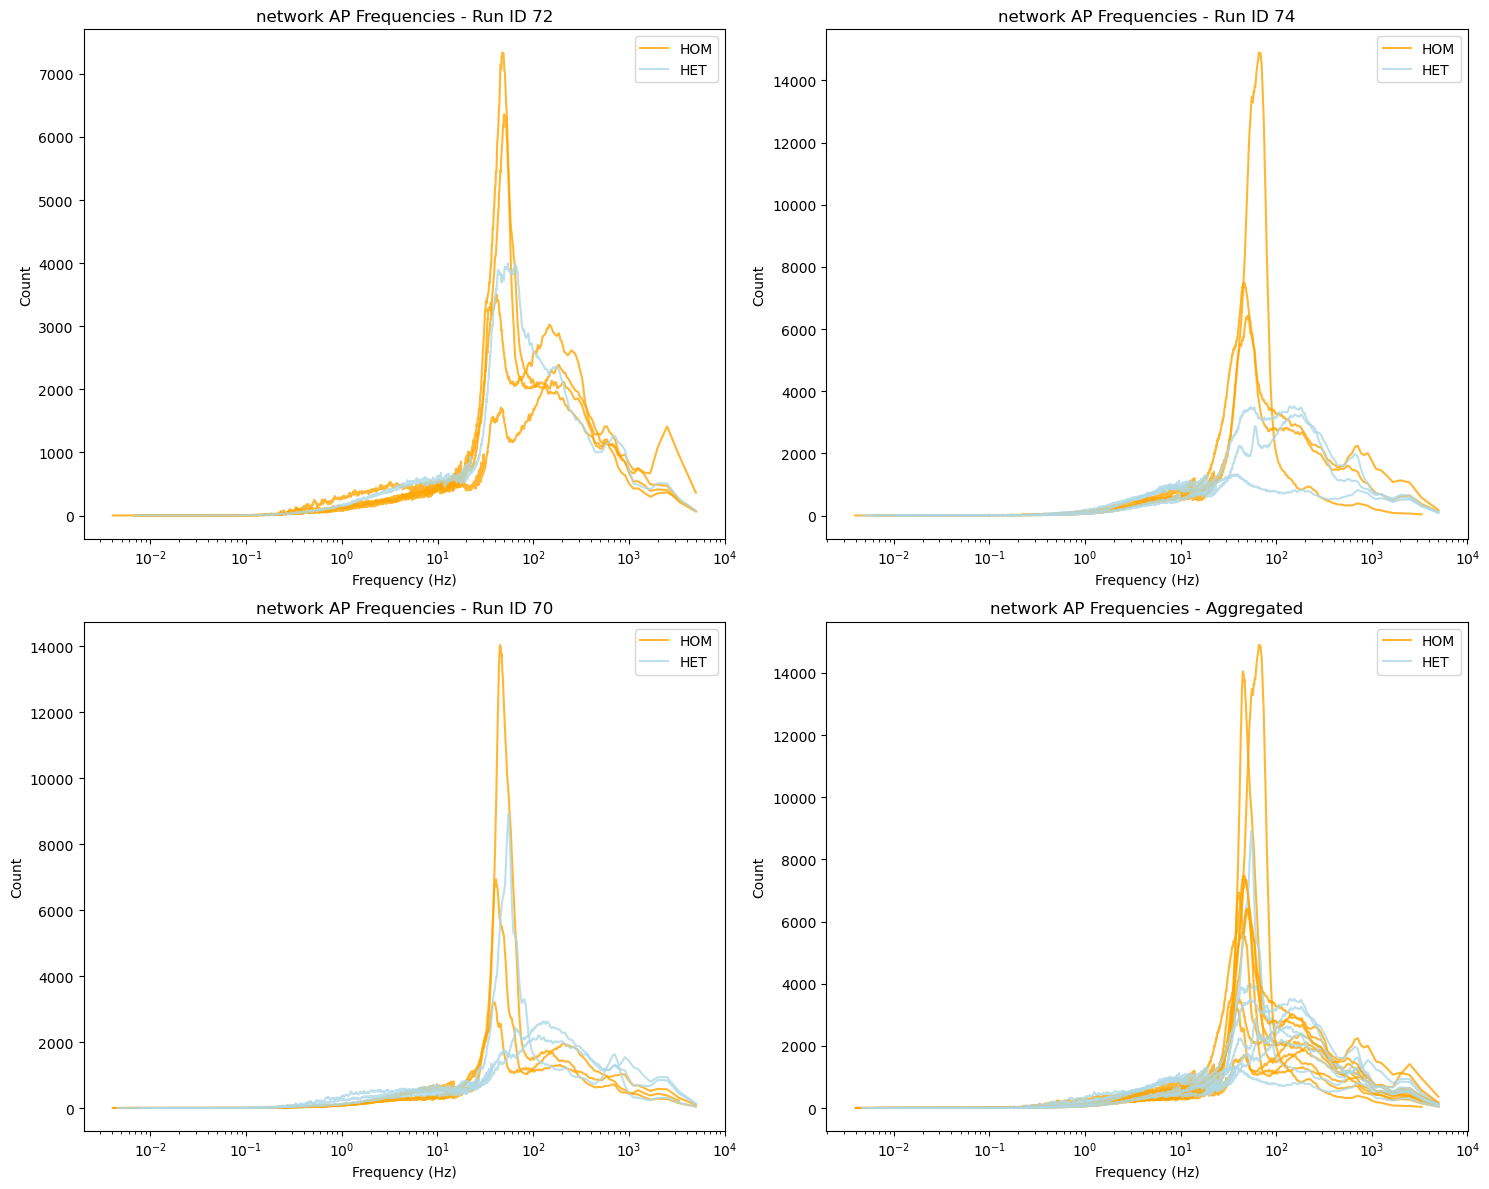

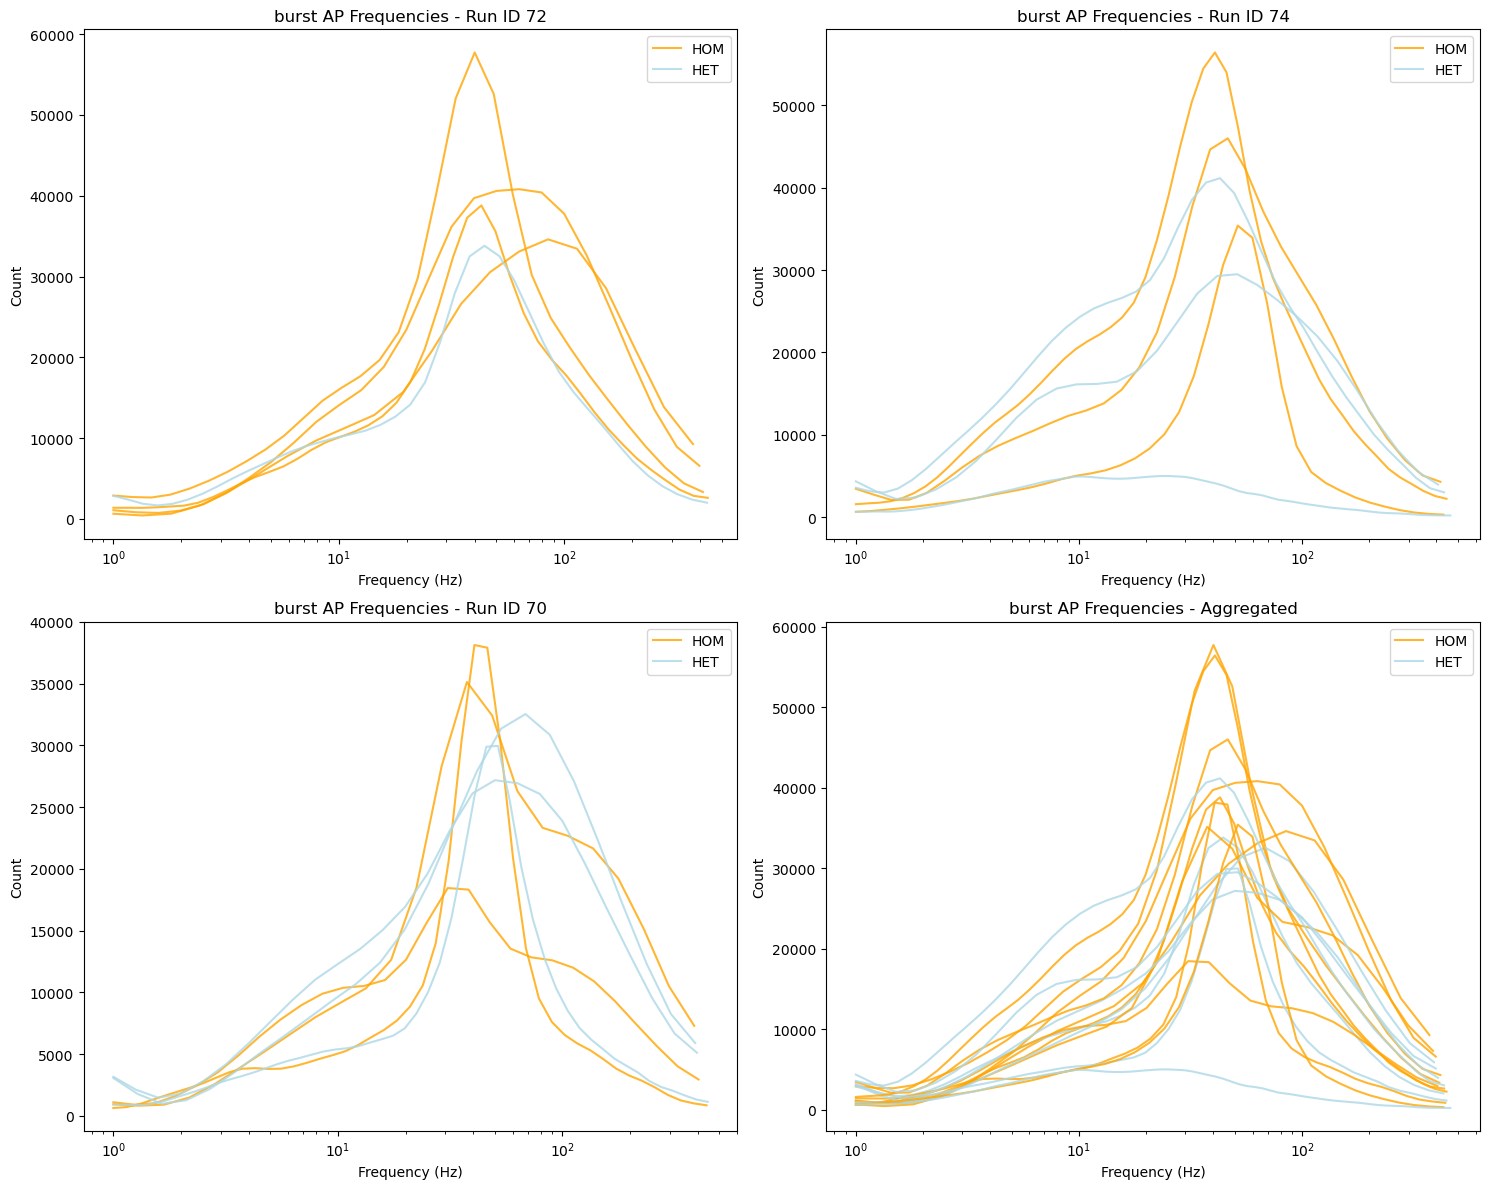

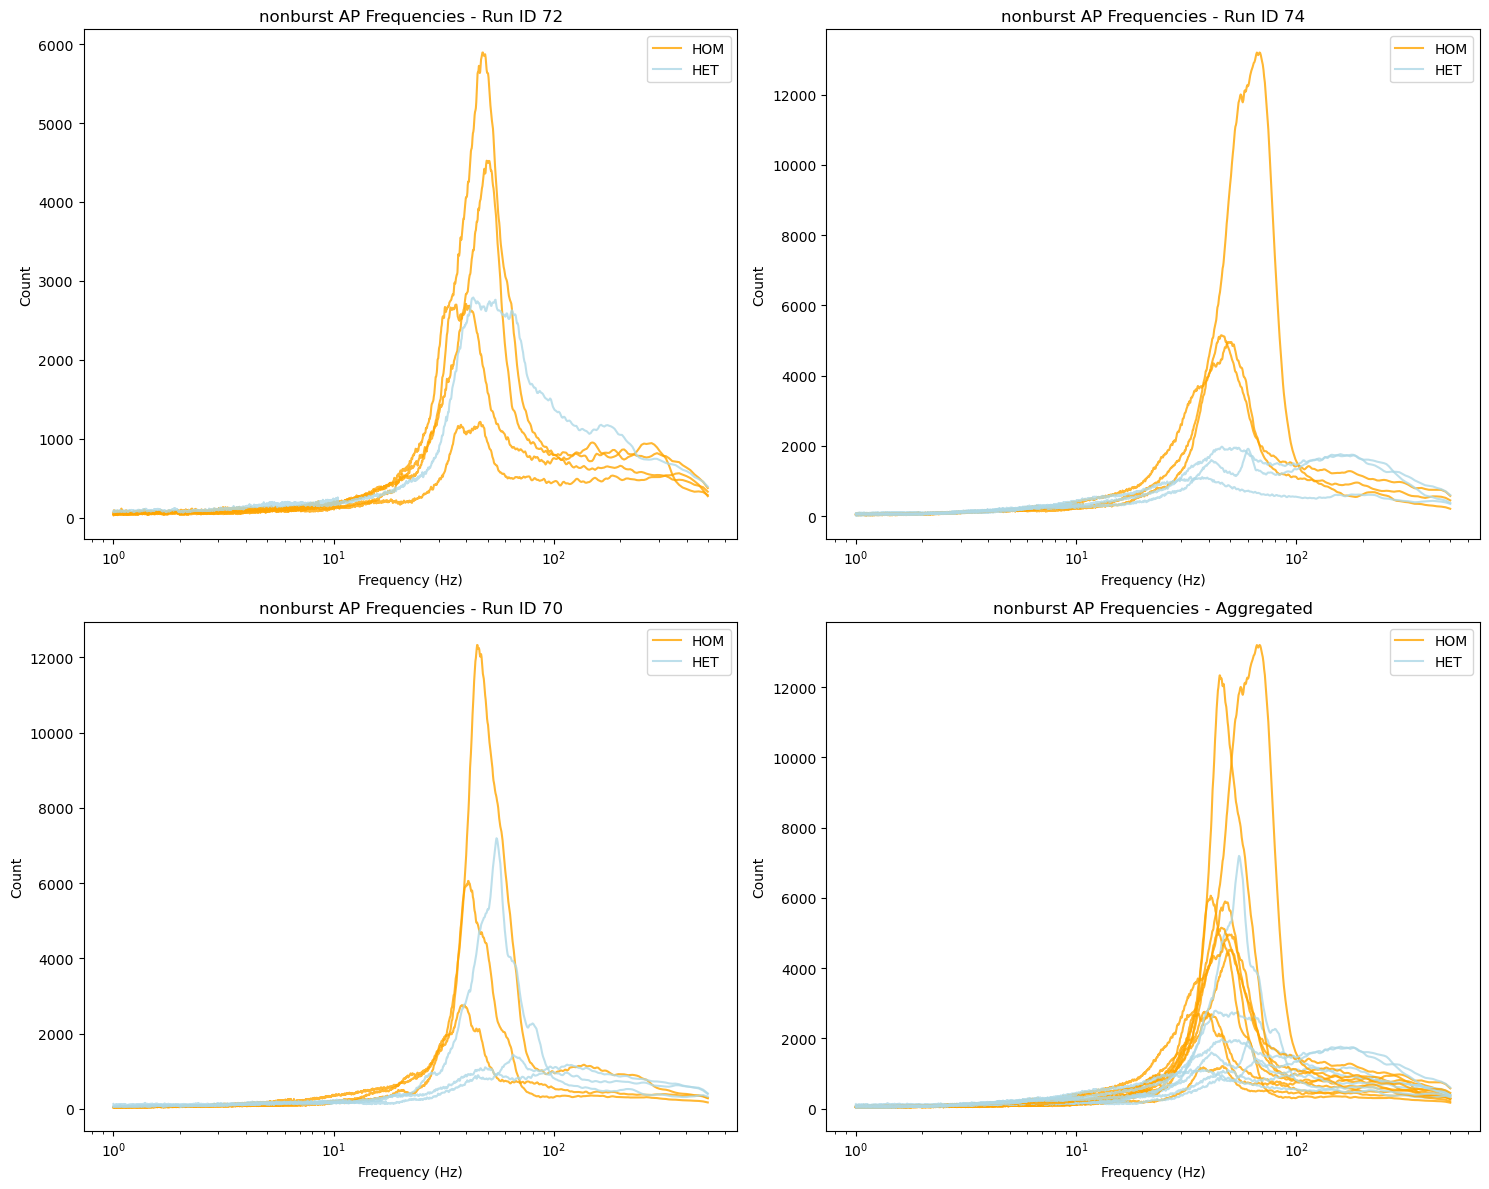

In [10]:
# Try denoising the data
def plot_line_denoise(data):
    colors = {'HOM': 'orange', 'HET': 'lightblue'}
    transparencies = {'HOM': 0.8, 'HET': 0.8}
    unique_run_ids = list(set(item['Run_ID'] for item in data))[:3]  # Ensure this matches the IDs you have.

    # Define the keys for different AP frequency categories
    keys = ['networkAPFreqBins', 'burstAPFreqBins', 'nonburstAPFreqBins']

    # Assuming all entries share the same edges
    max_edges = None
    for item in data:
        if max_edges is None or len(item['networkAPFreqEdges']) > len(max_edges):
            max_edges = item['networkAPFreqEdges']

    # Create figures for each category
    for key in keys:
        plt.figure(figsize=(15, 12))  # Figure size as specified

        # Plot for each Run_ID and for aggregate in the 4th subplot
        subplot_idx = 1
        for run_id in unique_run_ids + ['Aggregate']:
            ax = plt.subplot(2, 2, subplot_idx)
            subplot_idx += 1  # Increment subplot index

            if run_id != 'Aggregate':
                run_data = [item for item in data if item['Run_ID'] == run_id]
            else:
                run_data = data  # Aggregate uses all data

            aggregate_data = {nt: np.zeros_like(max_edges[:-1]) for nt in ['HOM', 'HET']} # Initialize aggregate data
            
            neuron_legend_added = {'HOM': False, 'HET': False}  # To control legend entry for each subplot

            for item in run_data:
                bins = item[key]
                edges = item[key.replace('Bins', 'Edges')]
                neuron_type = item['NeuronType']

                # Filter out zero data
                mask = bins != 0
                filtered_bins = bins[mask]
                filtered_edges = edges[:-1][mask]

                # Smooth data
                smoothed_bins = gaussian_filter1d(filtered_bins, sigma=1)

                # Interpolate to the standardized edges
                interp = interp1d(filtered_edges, smoothed_bins, kind='previous', bounds_error=False, fill_value=0)
                standardized_bins = interp(max_edges[:-1])

                # Update aggregate data
                aggregate_data[neuron_type] += standardized_bins

                # Compute midpoints for edges
                midpoints = (max_edges[:-1] + max_edges[1:]) / 2

                # Plot data with transparency
                alpha = transparencies[neuron_type]
                plt.plot(filtered_edges, smoothed_bins, color=colors[neuron_type], alpha=alpha, label=neuron_type if not neuron_legend_added[neuron_type] else "")
                
                # Ensure legend is added once per neuron type across all subplots
                if not neuron_legend_added[neuron_type]:
                    neuron_legend_added[neuron_type] = True

            plt.xscale('log')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Count')
            plt.title(f"{key.replace('APFreqBins', ' AP Frequencies')} - {'Aggregated' if run_id == 'Aggregate' else f'Run ID {run_id}'}")
            plt.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

plot_line_denoise(div_21_data)

**Bonus Task**

**Way 1: Percentage Normalization**

Before plotting, each set of data is divided by the maximum count found after smoothing, which normalizes the data to a range between 0 and 1 within each subplot. In this case, we present data in percentage.

Percentage Normalization is a powerful technique for visual comparison that can enhance the clarity and visibility of data trends. However, it is essential to consider the potential drawbacks, such as the loss of absolute information and the risk of misinterpretation, and to ensure that the context and importance of absolute values are taken into account when interpreting the results. 

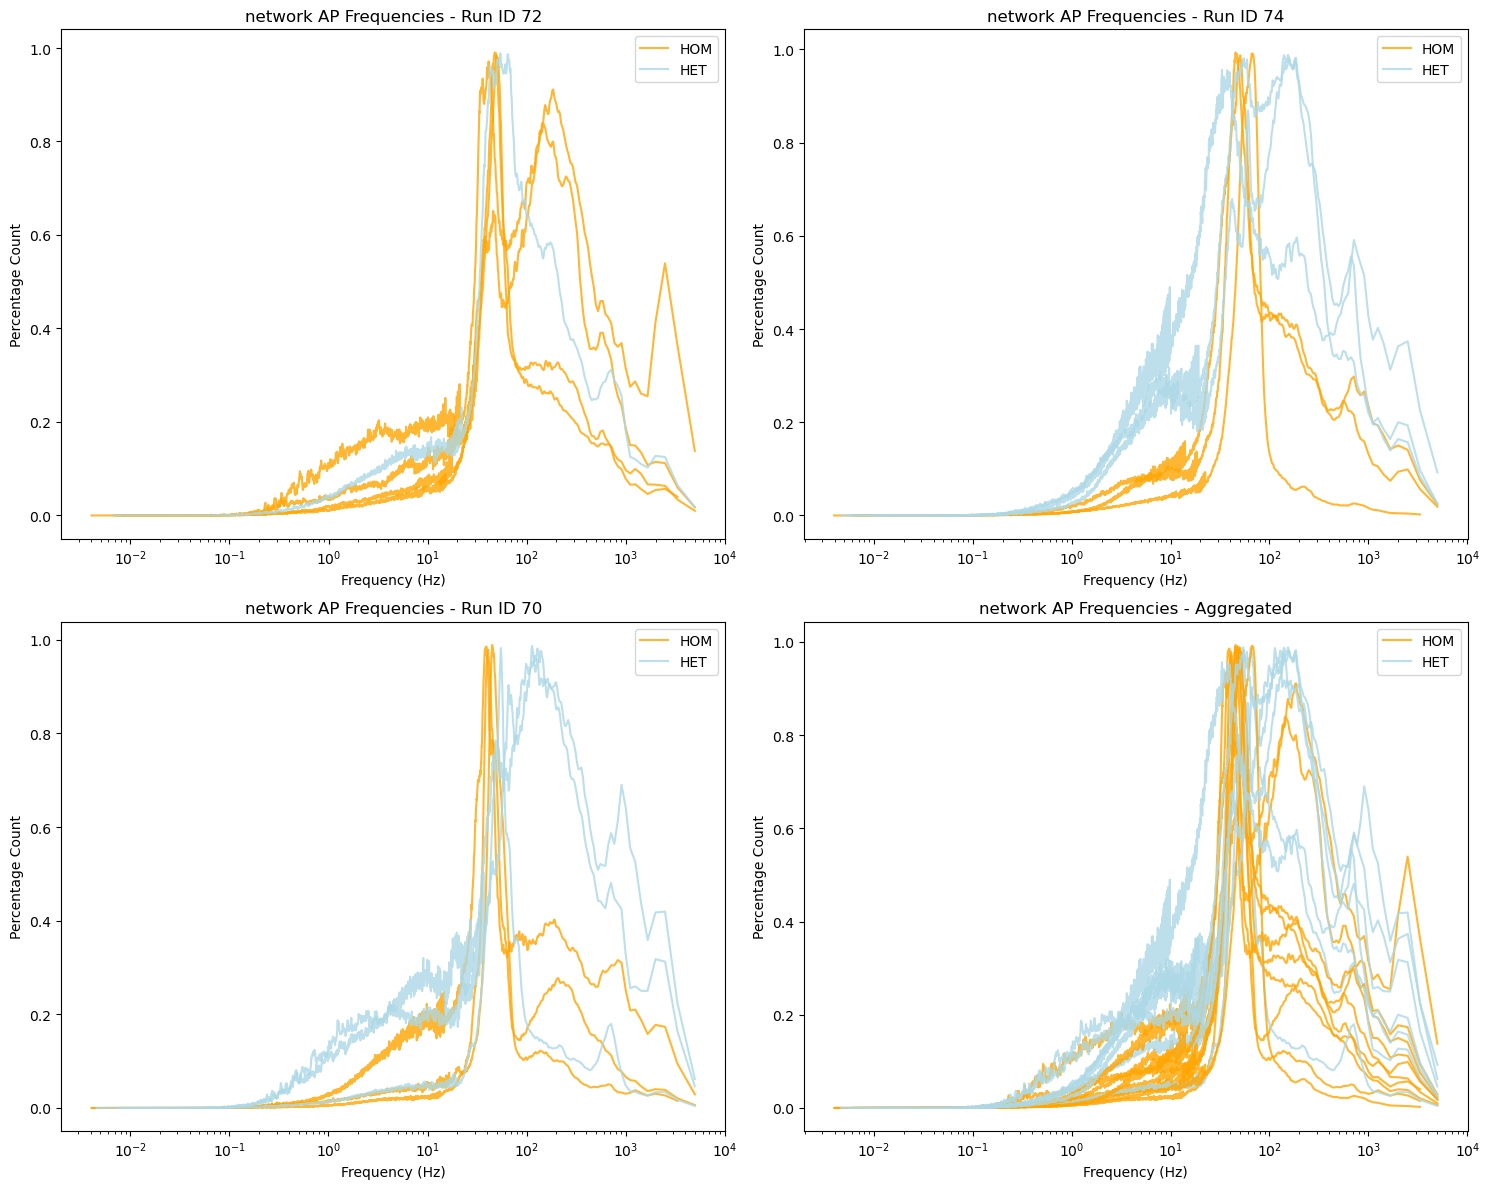

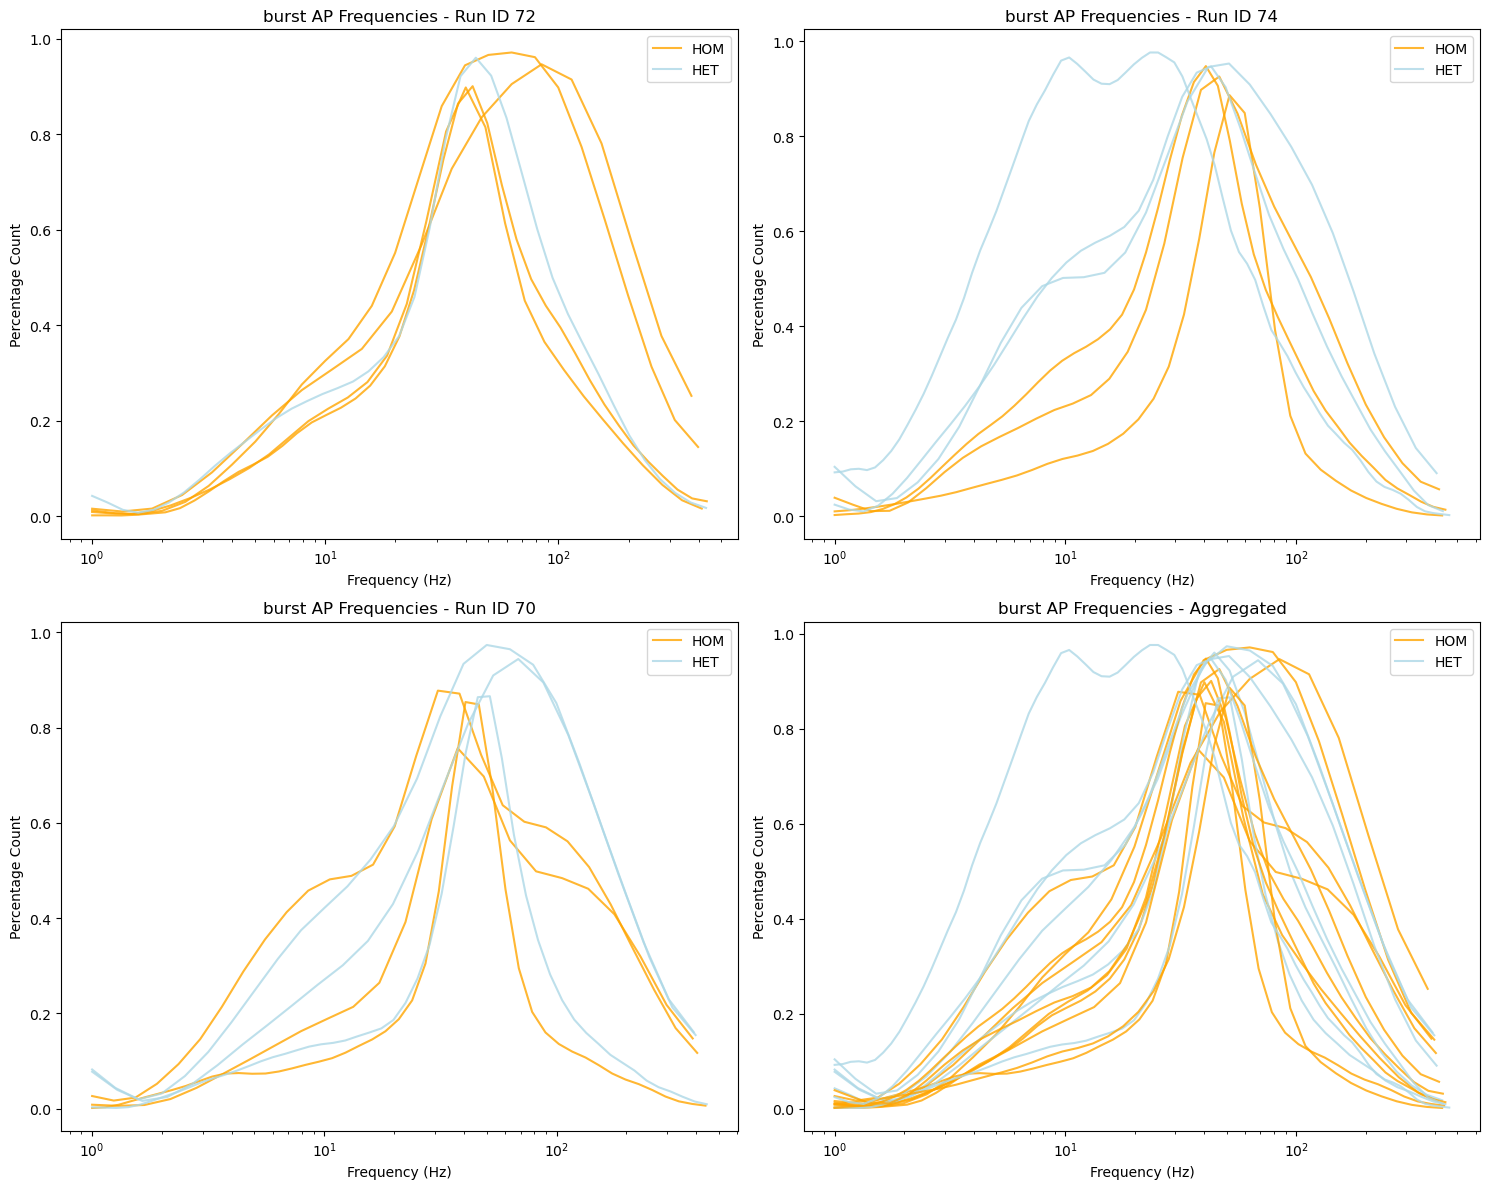

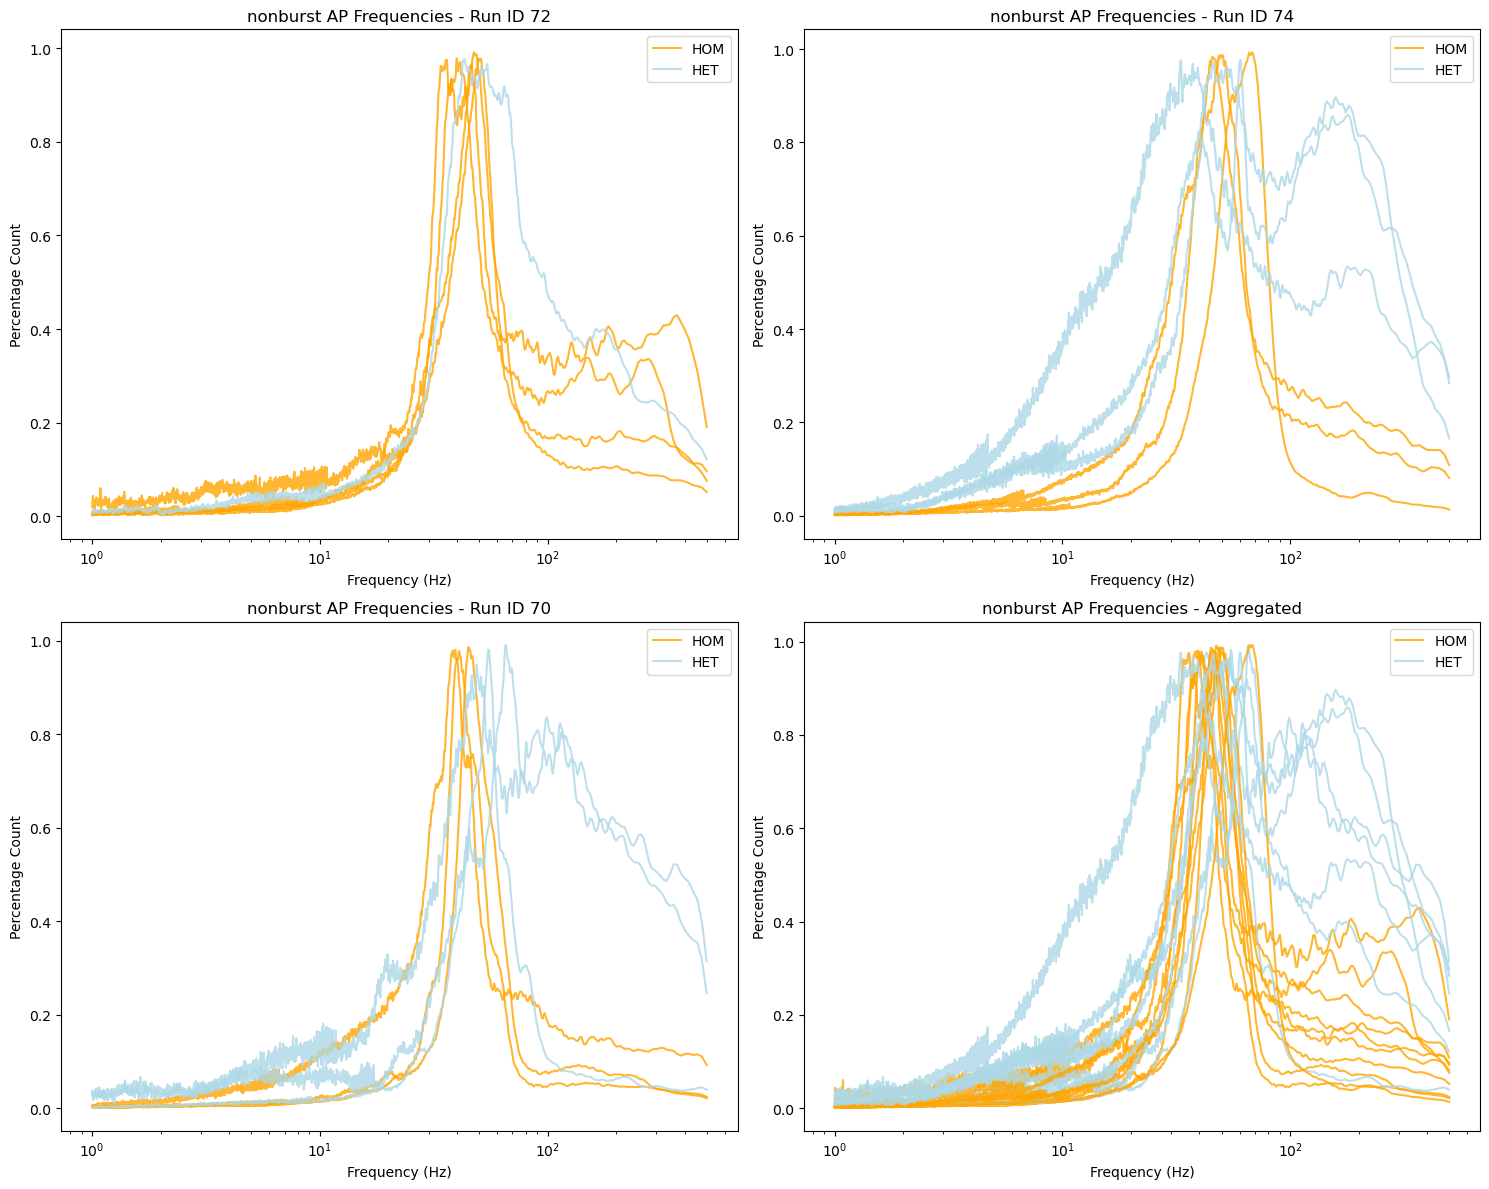

In [11]:
def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

def plot_line_normalize_percentage(data):
    colors = {'HOM': 'orange', 'HET': 'lightblue'}
    transparencies = {'HOM': 0.8, 'HET': 0.8}
    unique_run_ids = list(set(item['Run_ID'] for item in data))[:3]  # Ensure this matches the IDs you have.

    # Define the keys for different AP frequency categories
    keys = ['networkAPFreqBins', 'burstAPFreqBins', 'nonburstAPFreqBins']

    # Assuming all entries share the same edges
    max_edges = None
    for item in data:
        if max_edges is None or len(item['networkAPFreqEdges']) > len(max_edges):
            max_edges = item['networkAPFreqEdges']

    # Create figures for each category
    for key in keys:
        plt.figure(figsize=(15, 12))  # Figure size as specified

        # Plot for each Run_ID and for aggregate in the 4th subplot
        subplot_idx = 1
        for run_id in unique_run_ids + ['Aggregate']:
            ax = plt.subplot(2, 2, subplot_idx)
            subplot_idx += 1  # Increment subplot index

            if run_id != 'Aggregate':
                run_data = [item for item in data if item['Run_ID'] == run_id]
            else:
                run_data = data  # Aggregate uses all data

            aggregate_data = {nt: np.zeros_like(max_edges[:-1]) for nt in ['HOM', 'HET']} # Initialize aggregate data
            
            neuron_legend_added = {'HOM': False, 'HET': False}  # To control legend entry for each subplot

            for item in run_data:
                bins = item[key]
                edges = item[key.replace('Bins', 'Edges')]
                neuron_type = item['NeuronType']

                # Filter out zero data
                mask = bins != 0
                filtered_bins = bins[mask]
                filtered_edges = edges[:-1][mask]

                # Normalize data
                normalized_bins = min_max_normalize(filtered_bins)

                # Smooth data
                smoothed_bins = gaussian_filter1d(normalized_bins, sigma=1)

                # Interpolate to the standardized edges
                interp = interp1d(filtered_edges, smoothed_bins, kind='previous', bounds_error=False, fill_value=0)
                standardized_bins = interp(max_edges[:-1])

                # Update aggregate data
                aggregate_data[neuron_type] += standardized_bins

                # Compute midpoints for edges
                midpoints = (max_edges[:-1] + max_edges[1:]) / 2

                # Plot data with transparency
                alpha = transparencies[neuron_type]
                plt.plot(filtered_edges, smoothed_bins, color=colors[neuron_type], alpha=alpha, label=neuron_type if not neuron_legend_added[neuron_type] else "")
                
                # Ensure legend is added once per neuron type across all subplots
                if not neuron_legend_added[neuron_type]:
                    neuron_legend_added[neuron_type] = True

            plt.xscale('log')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Percentage Count')
            plt.title(f"{key.replace('APFreqBins', ' AP Frequencies')} - {'Aggregated' if run_id == 'Aggregate' else f'Run ID {run_id}'}")
            plt.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

plot_line_normalize_percentage(div_21_data)


**Way 2: Z-score Normalization (Standardlization)**

Z-score normalization, also known as standardization, involves transforming data to have a mean of zero and a standard deviation of one. 

Z-score normalization centers and scales data, enabling easy comparison across datasets with different units or scales. It highlights outliers, as extreme values become more evident in standard deviation units, and improves the performance of machine learning algorithms that rely on distance calculations. However, it removes the original scale, which can be important when absolute values matter, and is sensitive to extreme outliers that can skew results. Additionally, standardized values are less intuitive to interpret, making it harder to grasp practical implications. 

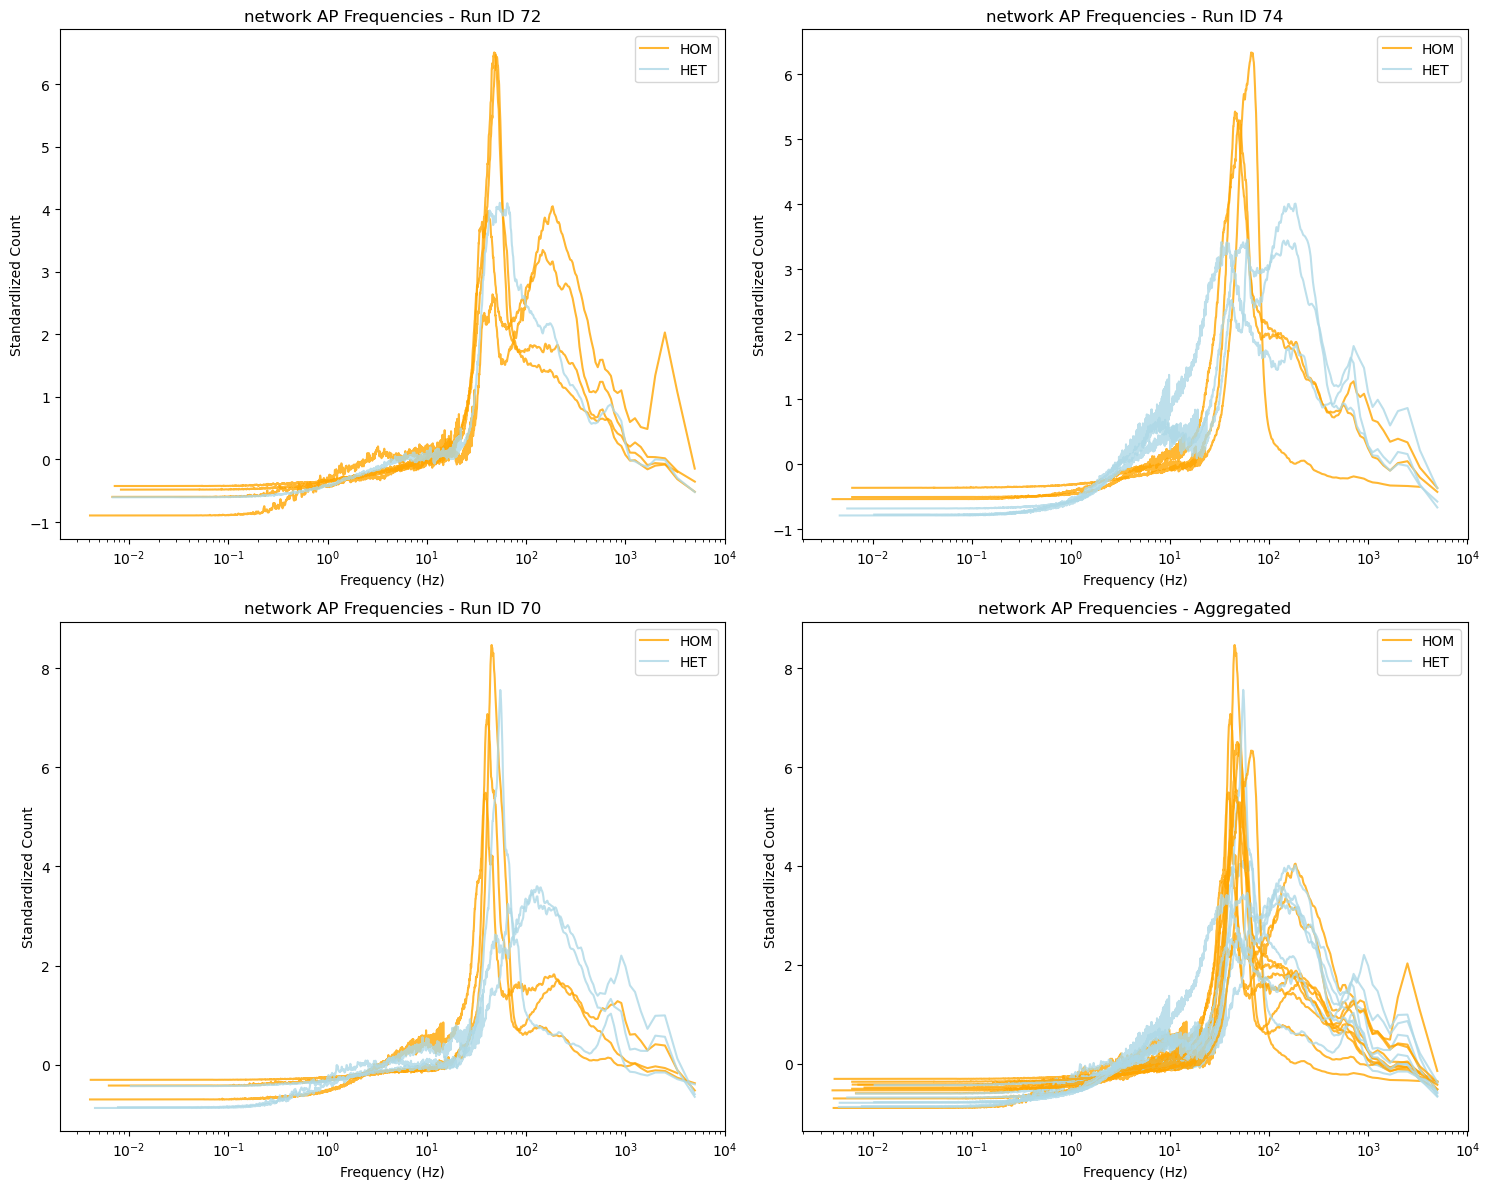

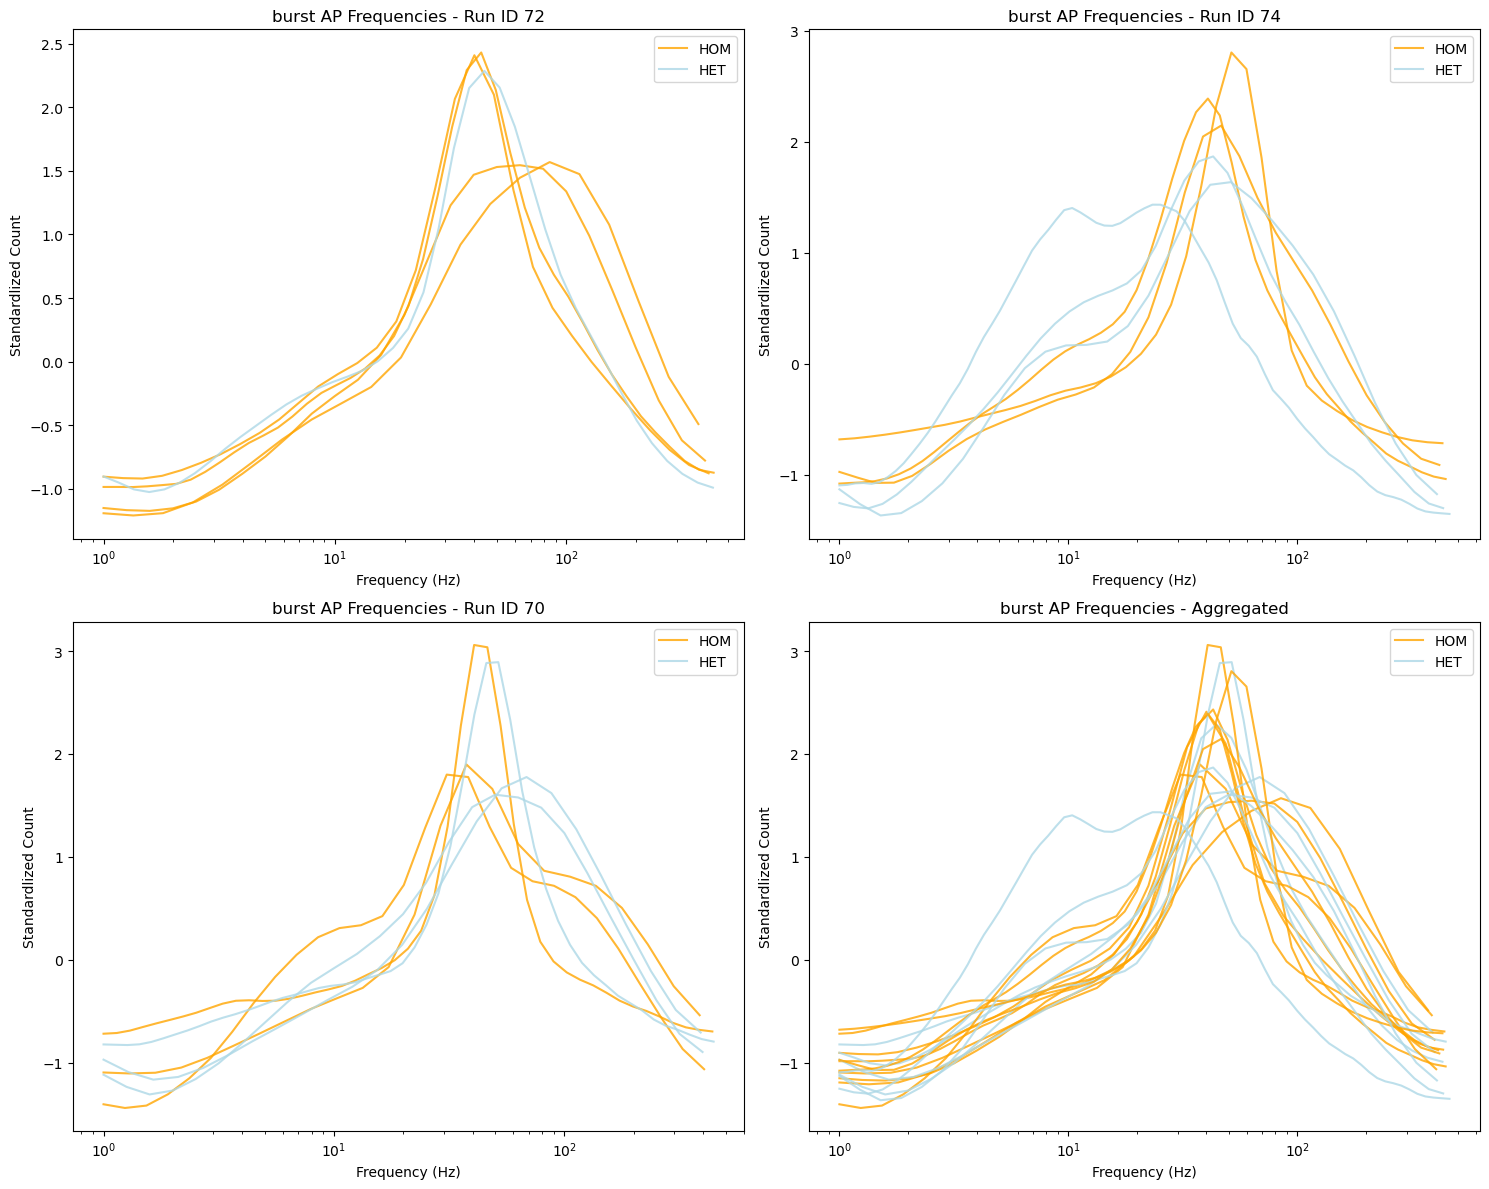

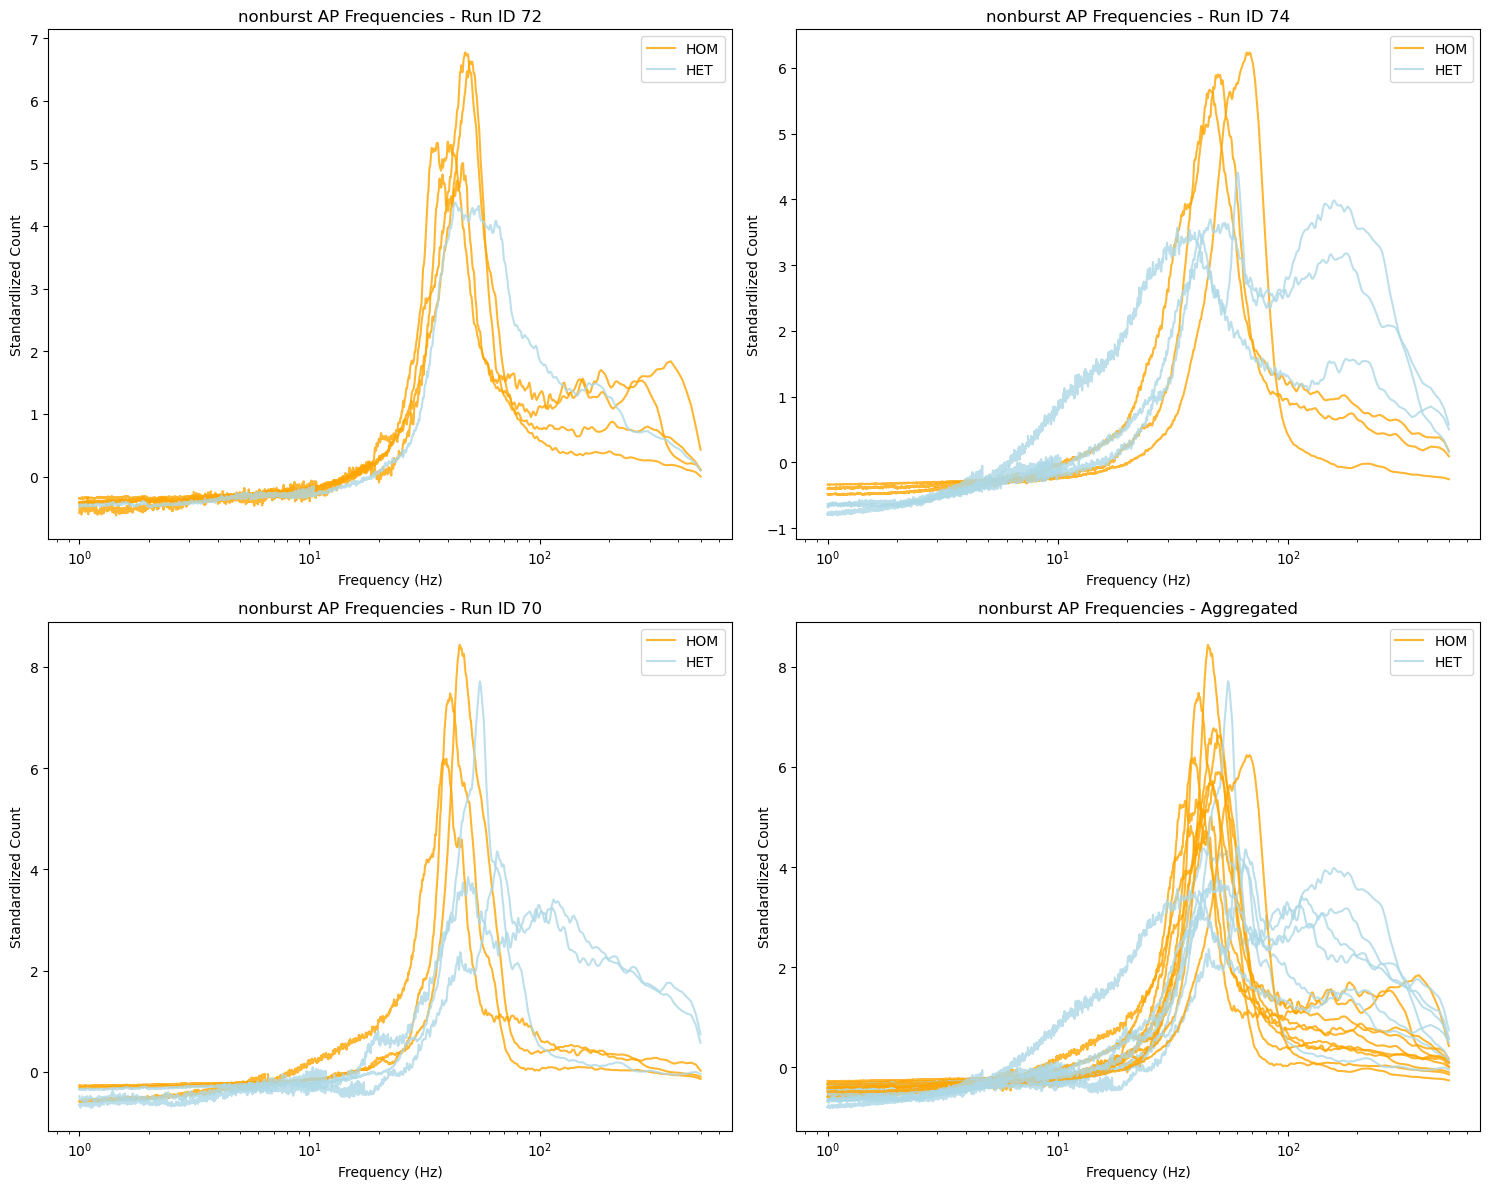

In [12]:
def z_score_normalize(data):
    mean_val = np.mean(data)
    std_val = np.std(data)
    return (data - mean_val) / std_val

def plot_normalize_z_score(data):
    colors = {'HOM': 'orange', 'HET': 'lightblue'}
    transparencies = {'HOM': 0.8, 'HET': 0.8}
    unique_run_ids = list(set(item['Run_ID'] for item in data))[:3]  # Ensure this matches the IDs you have.

    # Define the keys for different AP frequency categories
    keys = ['networkAPFreqBins', 'burstAPFreqBins', 'nonburstAPFreqBins']

    # Assuming all entries share the same edges
    max_edges = None
    for item in data:
        if max_edges is None or len(item['networkAPFreqEdges']) > len(max_edges):
            max_edges = item['networkAPFreqEdges']

    # Create figures for each category
    for key in keys:
        plt.figure(figsize=(15, 12))  # Figure size as specified

        # Plot for each Run_ID and for aggregate in the 4th subplot
        subplot_idx = 1
        for run_id in unique_run_ids + ['Aggregate']:
            ax = plt.subplot(2, 2, subplot_idx)
            subplot_idx += 1  # Increment subplot index

            if run_id != 'Aggregate':
                run_data = [item for item in data if item['Run_ID'] == run_id]
            else:
                run_data = data  # Aggregate uses all data

            aggregate_data = {nt: np.zeros_like(max_edges[:-1]) for nt in ['HOM', 'HET']} # Initialize aggregate data
            
            neuron_legend_added = {'HOM': False, 'HET': False}  # To control legend entry for each subplot

            for item in run_data:
                bins = item[key]
                edges = item[key.replace('Bins', 'Edges')]
                neuron_type = item['NeuronType']

                # Filter out zero data
                mask = bins != 0
                filtered_bins = bins[mask]
                filtered_edges = edges[:-1][mask]

                # Normalize data
                normalized_bins = z_score_normalize(filtered_bins)

                # Smooth data
                smoothed_bins = gaussian_filter1d(normalized_bins, sigma=1)

                # Interpolate to the standardized edges
                interp = interp1d(filtered_edges, smoothed_bins, kind='previous', bounds_error=False, fill_value=0)
                standardized_bins = interp(max_edges[:-1])

                # Update aggregate data
                aggregate_data[neuron_type] += standardized_bins

                # Compute midpoints for edges
                midpoints = (max_edges[:-1] + max_edges[1:]) / 2

                # Plot data with transparency
                alpha = transparencies[neuron_type]
                plt.plot(filtered_edges, smoothed_bins, color=colors[neuron_type], alpha=alpha, label=neuron_type if not neuron_legend_added[neuron_type] else "")
                
                # Ensure legend is added once per neuron type across all subplots
                if not neuron_legend_added[neuron_type]:
                    neuron_legend_added[neuron_type] = True

            plt.xscale('log')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Standardlized Count')
            plt.title(f"{key.replace('APFreqBins', ' AP Frequencies')} - {'Aggregated' if run_id == 'Aggregate' else f'Run ID {run_id}'}")
            plt.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

plot_normalize_z_score(div_21_data)

**Way 3: Separate Y-Axes**
Using dual y-axes with different scales for different datasets.

This method allows for precise visualization of datasets with different scales, preserving their absolute values. However, it can be confusing and may obscure relative comparisons between datasets, necessitating careful consideration in presentation and interpretation.

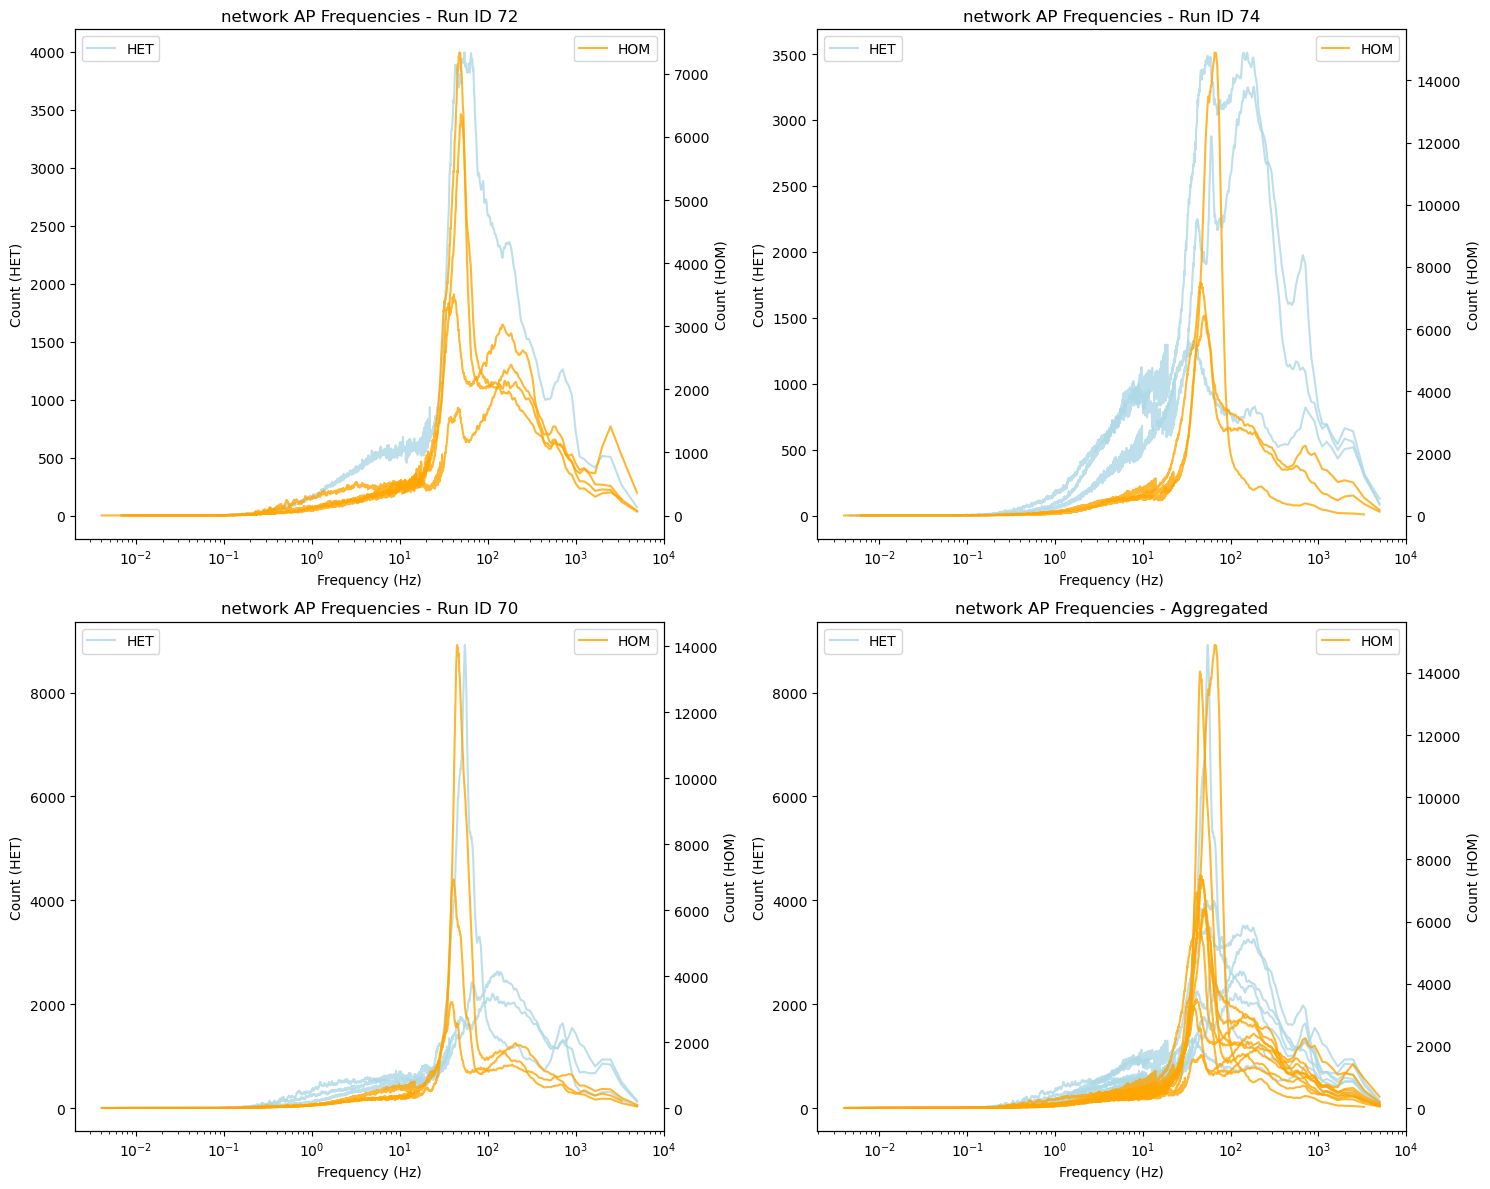

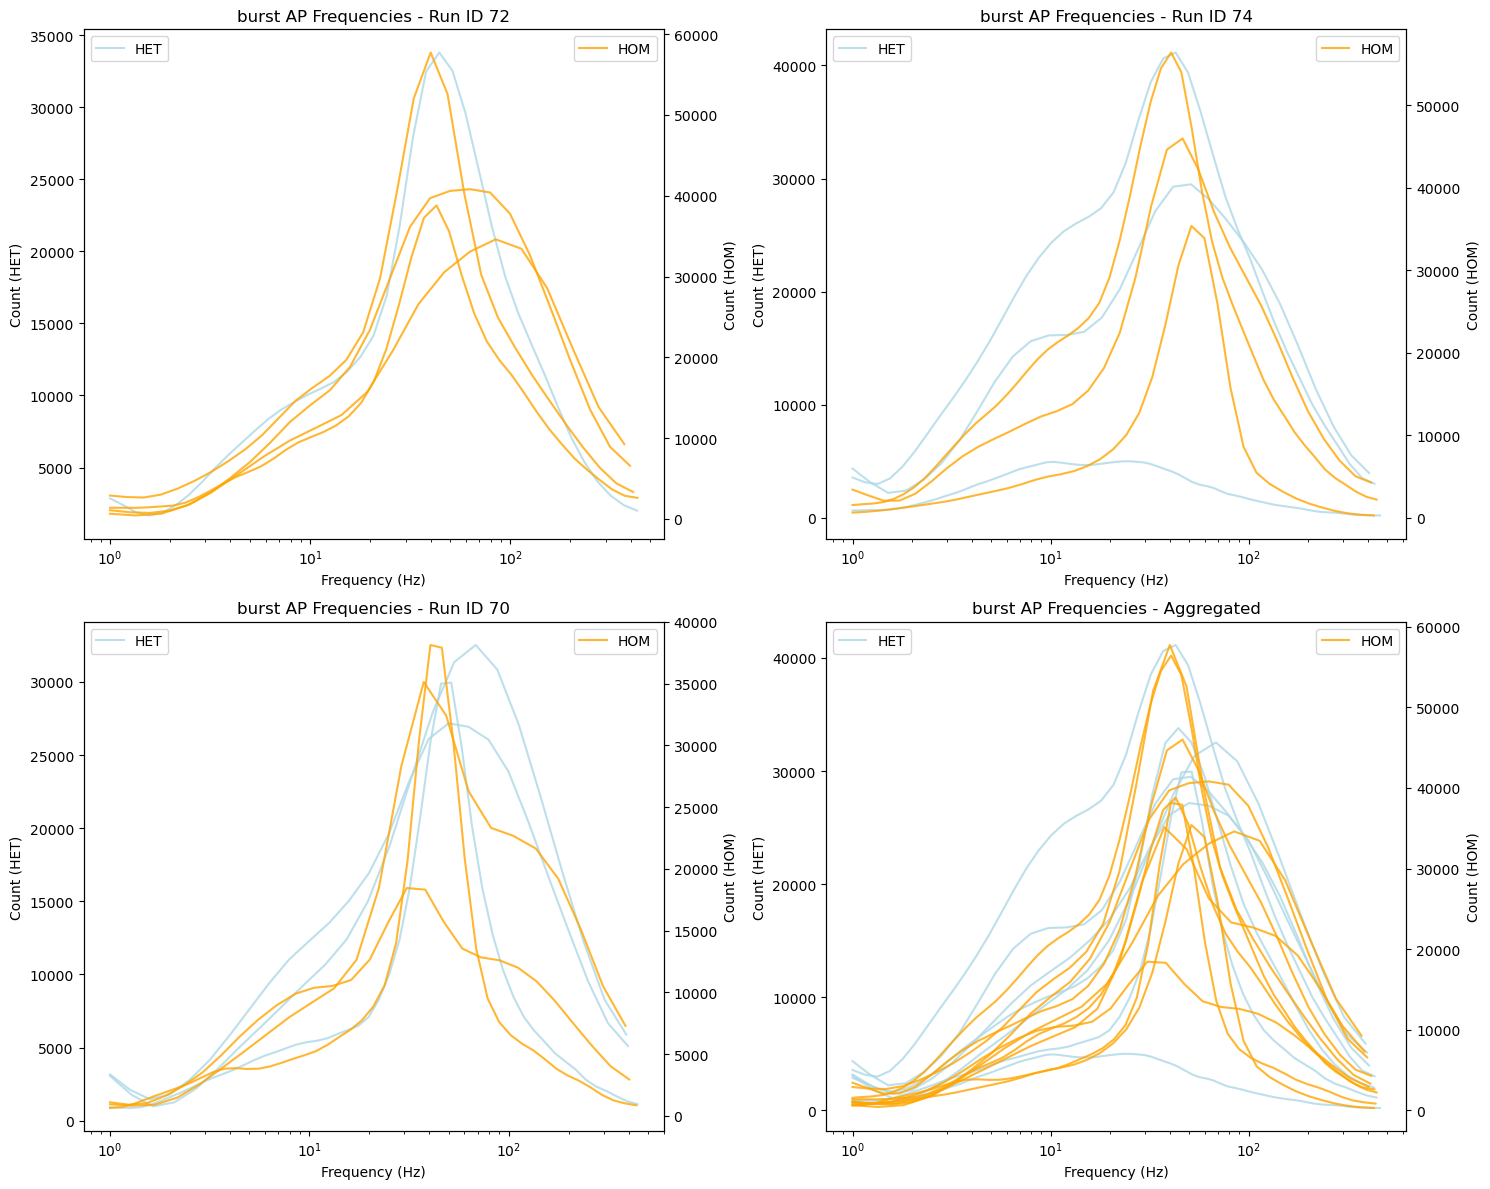

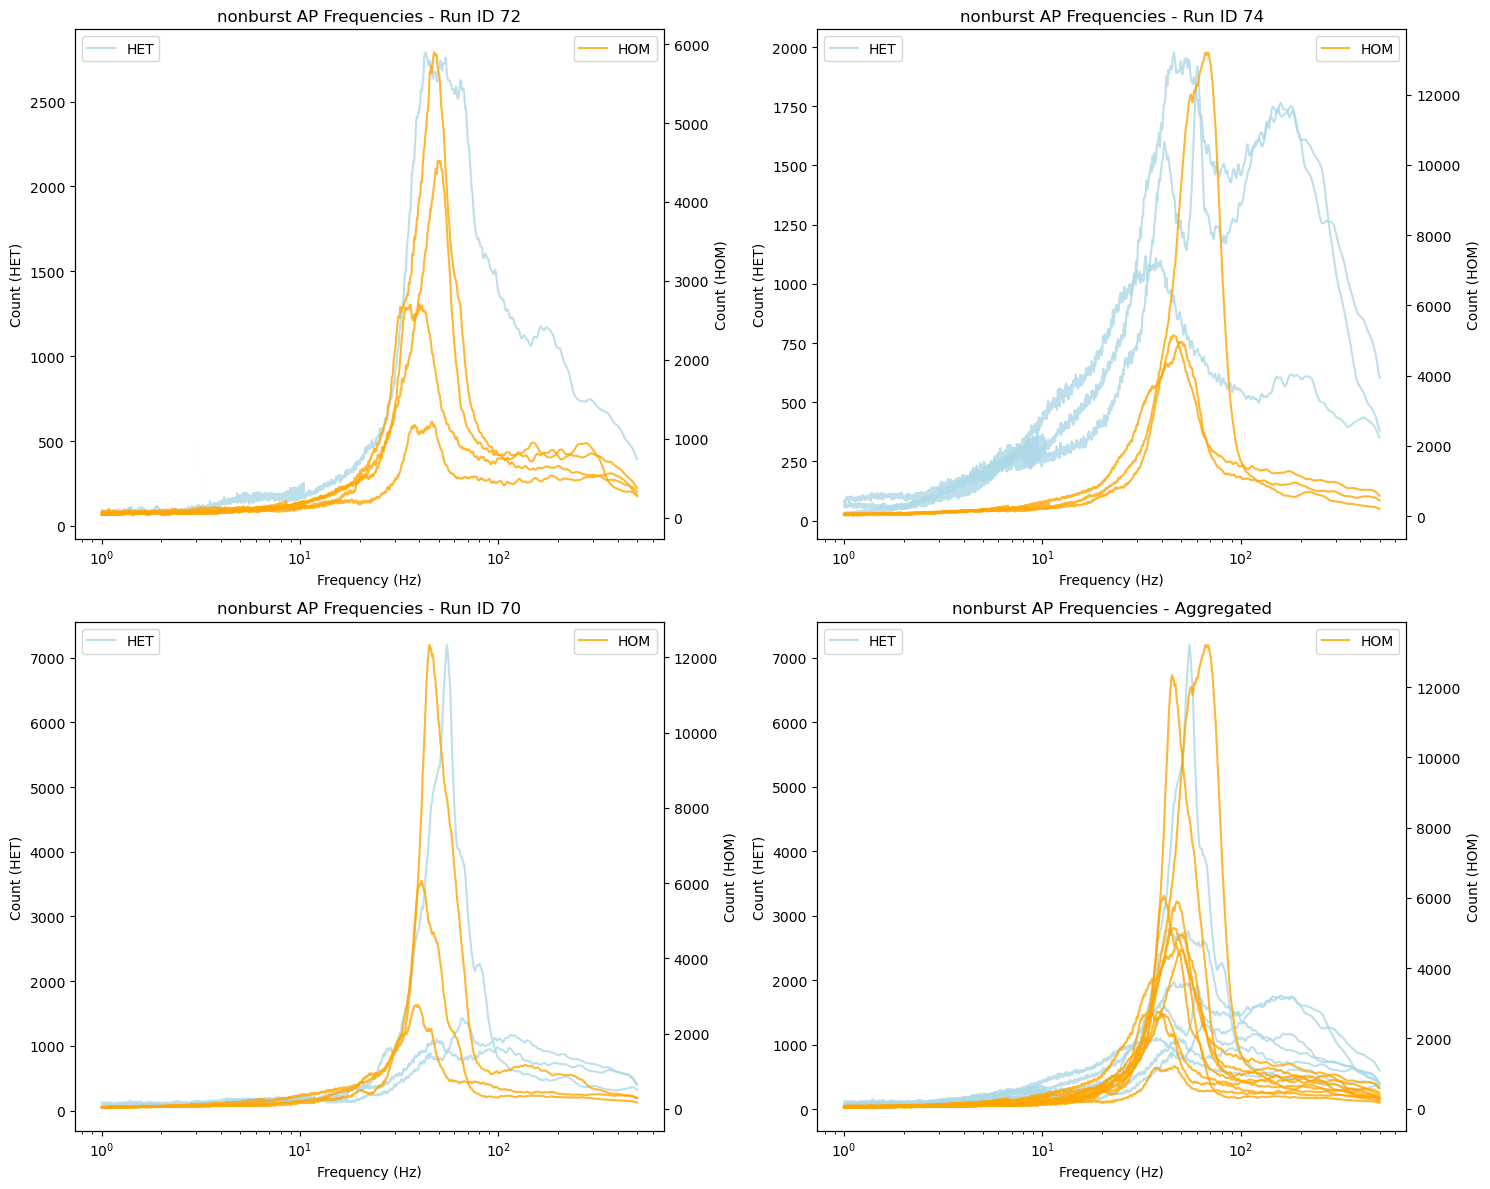

In [13]:
def plot_line_dual_y(data):
    colors = {'HOM': 'orange', 'HET': 'lightblue'}
    transparencies = {'HOM': 0.8, 'HET': 0.8}
    unique_run_ids = list(set(item['Run_ID'] for item in data))[:3]  # Ensure this matches the IDs you have.

    # Define the keys for different AP frequency categories
    keys = ['networkAPFreqBins', 'burstAPFreqBins', 'nonburstAPFreqBins']

    # Assuming all entries share the same edges
    max_edges = None
    for item in data:
        if max_edges is None or len(item['networkAPFreqEdges']) > len(max_edges):
            max_edges = item['networkAPFreqEdges']

    # Create figures for each category
    for key in keys:
        plt.figure(figsize=(15, 12))  # Figure size as specified

        # Plot for each Run_ID and for aggregate in the 4th subplot
        subplot_idx = 1
        for run_id in unique_run_ids + ['Aggregate']:
            ax = plt.subplot(2, 2, subplot_idx)
            subplot_idx += 1  # Increment subplot index

            if run_id != 'Aggregate':
                run_data = [item for item in data if item['Run_ID'] == run_id]
            else:
                run_data = data  # Aggregate uses all data

            aggregate_data = {nt: np.zeros_like(max_edges[:-1]) for nt in ['HOM', 'HET']} # Initialize aggregate data
            
            neuron_legend_added = {'HOM': False, 'HET': False}  # To control legend entry for each subplot

            # Create secondary y-axis for HOM data
            ax2 = ax.twinx()

            for item in run_data:
                bins = item[key]
                edges = item[key.replace('Bins', 'Edges')]
                neuron_type = item['NeuronType']

                # Filter out zero data
                mask = bins != 0
                filtered_bins = bins[mask]
                filtered_edges = edges[:-1][mask]

                # Smooth data
                smoothed_bins = gaussian_filter1d(filtered_bins, sigma=1)

                # Interpolate to the standardized edges
                interp = interp1d(filtered_edges, smoothed_bins, kind='previous', bounds_error=False, fill_value=0)
                standardized_bins = interp(max_edges[:-1])

                # Update aggregate data
                aggregate_data[neuron_type] += standardized_bins

                # Compute midpoints for edges
                midpoints = (max_edges[:-1] + max_edges[1:]) / 2

                # Plot data with transparency
                alpha = transparencies[neuron_type]
                if neuron_type == 'HET':
                    ax.plot(filtered_edges, smoothed_bins, color=colors[neuron_type], alpha=alpha, label=neuron_type if not neuron_legend_added[neuron_type] else "")
                else:
                    ax2.plot(filtered_edges, smoothed_bins, color=colors[neuron_type], alpha=alpha, label=neuron_type if not neuron_legend_added[neuron_type] else "")

                # Ensure legend is added once per neuron type across all subplots
                if not neuron_legend_added[neuron_type]:
                    neuron_legend_added[neuron_type] = True

            ax.set_xscale('log')
            ax.set_xlabel('Frequency (Hz)')
            ax.set_ylabel('Count (HET)')
            ax2.set_ylabel('Count (HOM)')
            ax.set_title(f"{key.replace('APFreqBins', ' AP Frequencies')} - {'Aggregated' if run_id == 'Aggregate' else f'Run ID {run_id}'}")
            ax.legend(loc='upper left')
            ax2.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

plot_line_dual_y(div_21_data)

**Way 4: Logarithmic Scale**

Applying a logarithmic scale to y-axis so that help compress the range of data and make the visualization clearer, especially when data varies exponentially.

This method is beneficial for visualizing data with a wide range of values, revealing trends that may be missed on a linear scale. However, it requires careful handling of zero or negative values and may be less intuitive for some viewers, necessitating clear communication of its use and implications.

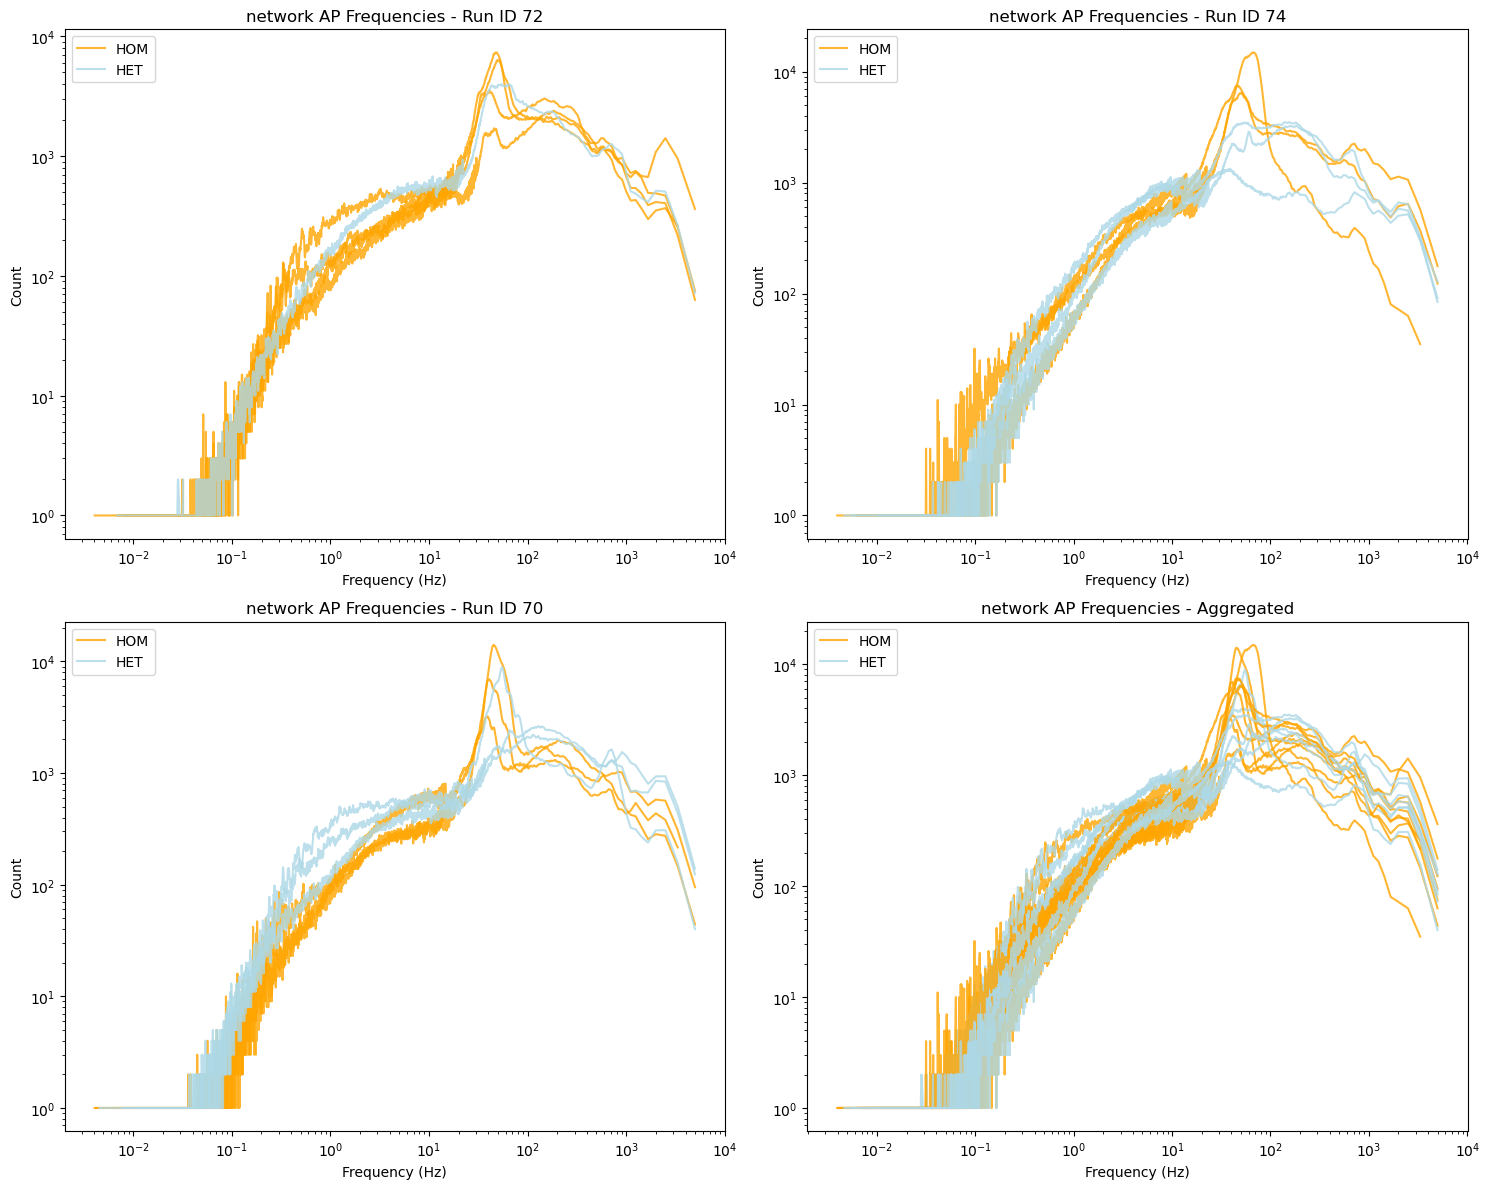

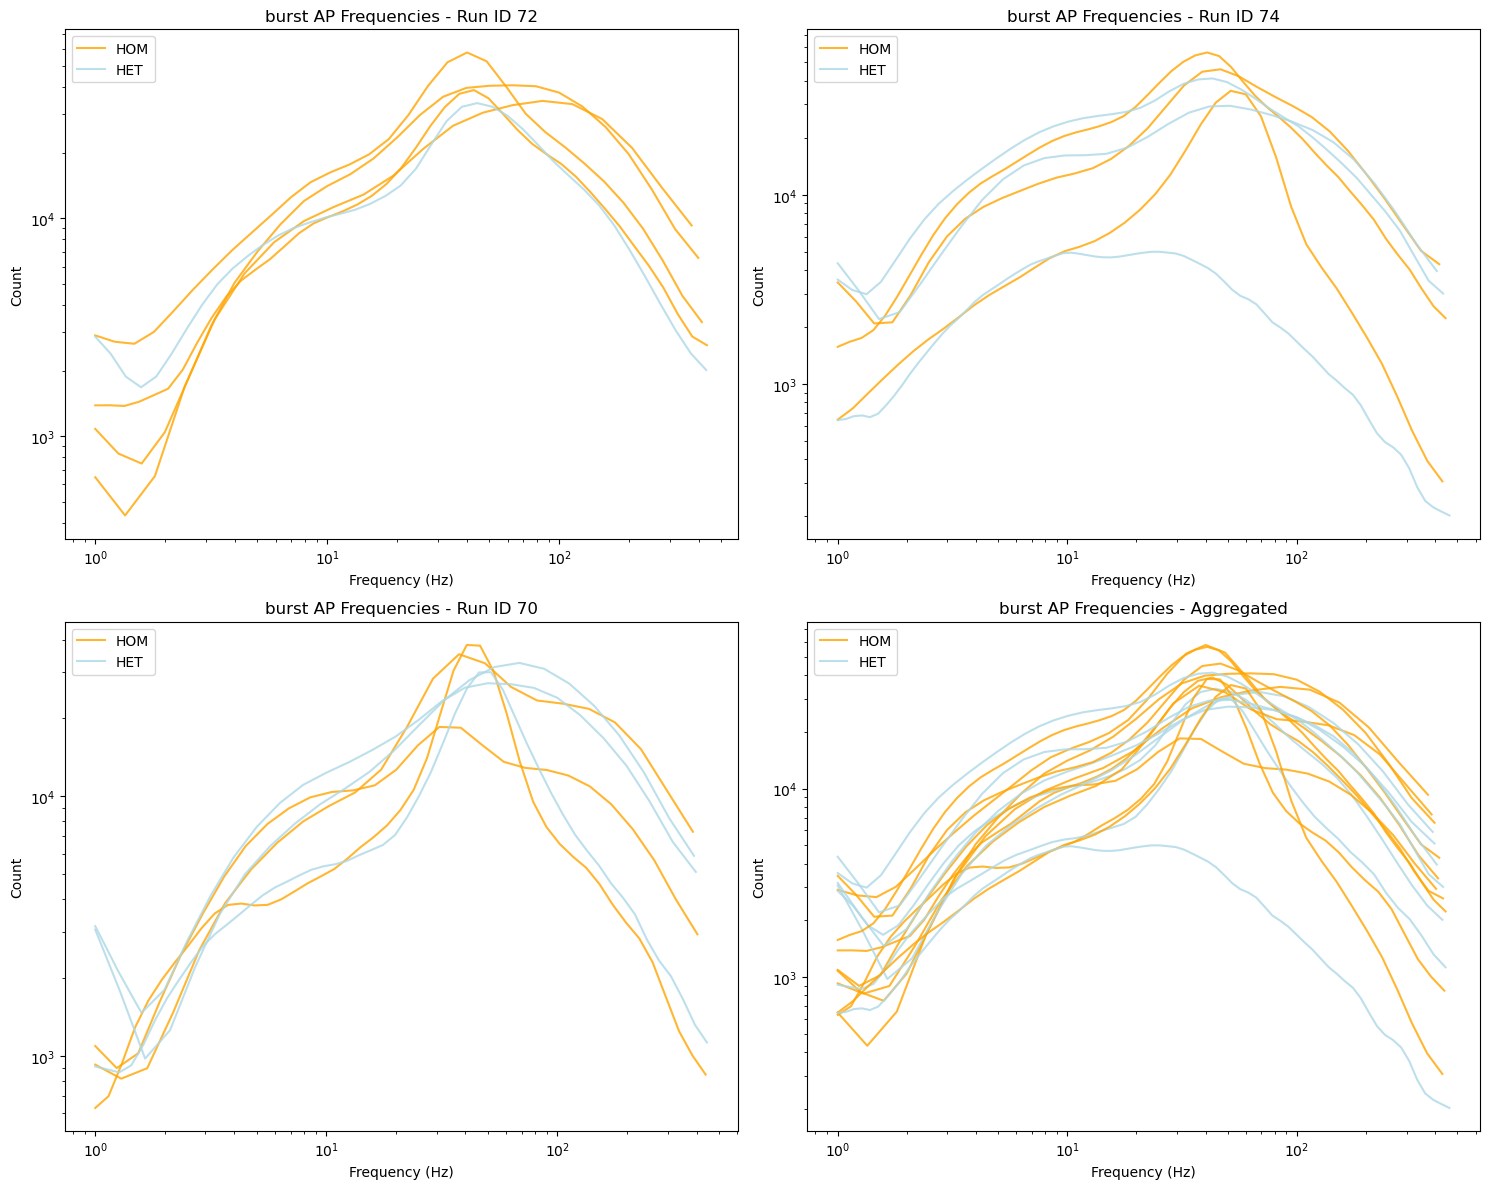

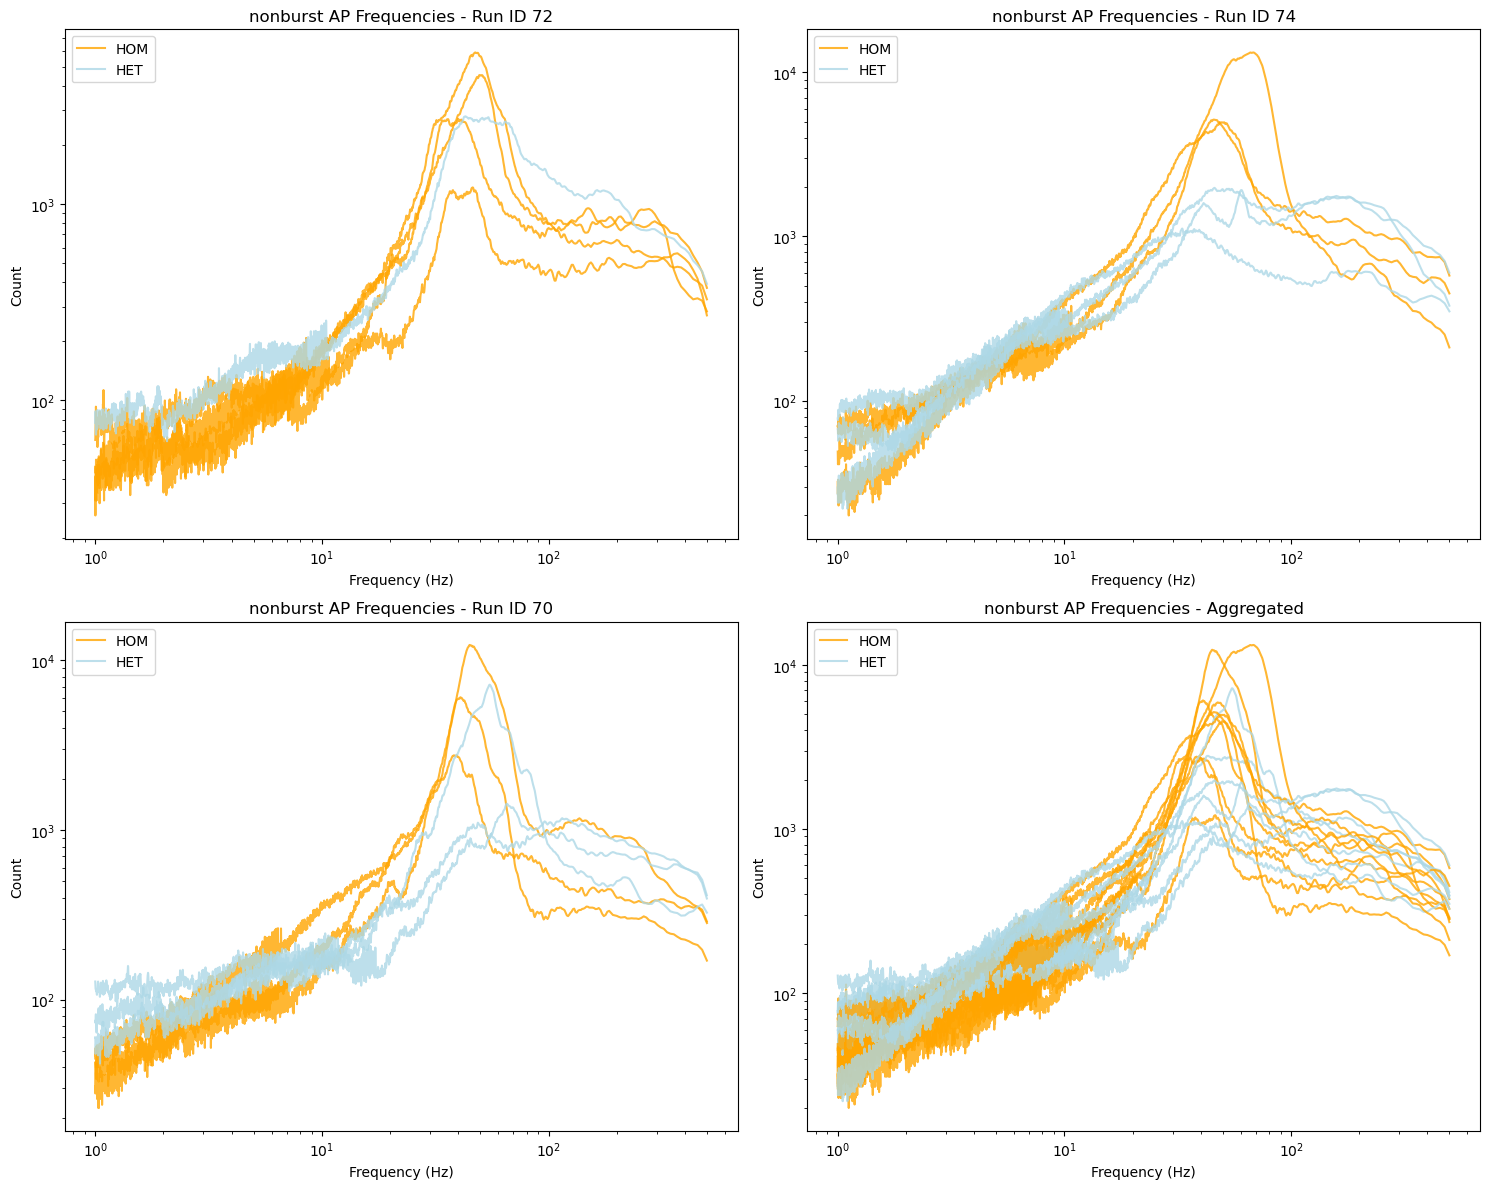

In [14]:
def plot_line_log(data):
    colors = {'HOM': 'orange', 'HET': 'lightblue'}
    transparencies = {'HOM': 0.8, 'HET': 0.8}
    unique_run_ids = list(set(item['Run_ID'] for item in data))[:3]  # Ensure this matches the IDs you have.

    # Define the keys for different AP frequency categories
    keys = ['networkAPFreqBins', 'burstAPFreqBins', 'nonburstAPFreqBins']

    # Assuming all entries share the same edges
    max_edges = None
    for item in data:
        if max_edges is None or len(item['networkAPFreqEdges']) > len(max_edges):
            max_edges = item['networkAPFreqEdges']

    # Create figures for each category
    for key in keys:
        plt.figure(figsize=(15, 12))  # Figure size as specified

        # Plot for each Run_ID and for aggregate in the 4th subplot
        subplot_idx = 1
        for run_id in unique_run_ids + ['Aggregate']:
            ax = plt.subplot(2, 2, subplot_idx)
            subplot_idx += 1  # Increment subplot index

            if run_id != 'Aggregate':
                run_data = [item for item in data if item['Run_ID'] == run_id]
            else:
                run_data = data  # Aggregate uses all data

            aggregate_data = {nt: np.zeros_like(max_edges[:-1]) for nt in ['HOM', 'HET']} # Initialize aggregate data
            
            neuron_legend_added = {'HOM': False, 'HET': False}  # To control legend entry for each subplot

            for item in run_data:
                bins = item[key]
                edges = item[key.replace('Bins', 'Edges')]
                neuron_type = item['NeuronType']

                # Filter out zero data
                mask = bins != 0
                filtered_bins = bins[mask]
                filtered_edges = edges[:-1][mask]

                # Smooth data
                smoothed_bins = gaussian_filter1d(filtered_bins, sigma=1)

                # Interpolate to the standardized edges
                interp = interp1d(filtered_edges, smoothed_bins, kind='previous', bounds_error=False, fill_value=0)
                standardized_bins = interp(max_edges[:-1])

                # Update aggregate data
                aggregate_data[neuron_type] += standardized_bins

                # Compute midpoints for edges
                midpoints = (max_edges[:-1] + max_edges[1:]) / 2

                # Plot data with transparency
                alpha = transparencies[neuron_type]
                ax.plot(filtered_edges, smoothed_bins, color=colors[neuron_type], alpha=alpha, label=neuron_type if not neuron_legend_added[neuron_type] else "")
                ax.set_yscale('log')  # Apply logarithmic scale to y-axis

                # Ensure legend is added once per neuron type across all subplots
                if not neuron_legend_added[neuron_type]:
                    neuron_legend_added[neuron_type] = True

            ax.set_xscale('log')
            ax.set_xlabel('Frequency (Hz)')
            ax.set_ylabel('Count')
            ax.set_title(f"{key.replace('APFreqBins', ' AP Frequencies')} - {'Aggregated' if run_id == 'Aggregate' else f'Run ID {run_id}'}")
            ax.legend(loc='upper left')

        plt.tight_layout()
        plt.show()

plot_line_log(div_21_data)